# Statistical Analysis Credit Cards

In [37]:
# Import required modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import seaborn as sns
from scipy.stats import ttest_ind
from datetime import datetime

In [39]:
pd.set_option('display.max_columns',None)

In [40]:
# Load the Credit Card Transactions dataset into a Pandas DataFrame.
credit_card_df = pd.read_csv('./credit_card_transactions_updated.csv',index_col=0)

In [41]:
credit_card_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,NaN,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,NaN,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,NaN,NaN,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,NaN,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,2019-01-01 00:03:06,375534208663984,NaN,misc_pos,NaN,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,NaN,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258.0,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,NaN
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100.0,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,22630.0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899.0,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,88351.0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126.0,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,69367.0


## Trasformation

In [42]:
# Calculate age from 'dob' column
credit_card_df['age'] = credit_card_df['dob'].apply(lambda x: datetime.now().year - datetime.strptime(x, '%Y-%m-%d').year)
# Create an age range category
def age_range_category(age):
    if age < 20:
        return 'Below 20'
    elif 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age < 50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    else:
        return '60 and above'
credit_card_df['age_range'] = credit_card_df['age'].apply(age_range_category)
# Display the new age_range column to verify
credit_card_df.drop(columns=['age'], inplace=True)
credit_card_df[['dob', 'age_range']].head()

,dob,age_range
0,1988-03-09,30-39
1,1978-06-21,40-49
2,1962-01-19,60 and above
3,1967-01-12,50-59
4,1986-03-28,30-39


In [43]:
credit_card_df['is_fraud'] = credit_card_df['is_fraud'].replace({1: 'Yes', 0: 'No'})

In [44]:
# Split trans_date_trans_time into multiple columns.
credit_card_df['trans_date_trans_time'] = pd.to_datetime(credit_card_df['trans_date_trans_time'])
credit_card_df['month'] = credit_card_df['trans_date_trans_time'].dt.month
credit_card_df['day'] = credit_card_df['trans_date_trans_time'].dt.day
credit_card_df['hour'] = credit_card_df['trans_date_trans_time'].dt.hour
credit_card_df['weekday'] = credit_card_df['trans_date_trans_time'].dt.day_name()

* merch_zipcode->  Here we can drop since it has a high correlation with merch lat and log. (merch_zipcode has a very high missing value)
*  unix_time -> since it has a high correlation with traction time.
* trans_num -> since it has all unique has no analytical significant.
* lat and log -> id direclty depend on city and state so not needed.


In [45]:
# drop_list = ['merch_zipcode', 'unix_time', 'trans_num',"lat",'long','Unnamed: 0.1','Unnamed: 0']
drop_list = ['merch_zipcode', 'unix_time', 'trans_num',"lat",'long']
credit_card_df.drop(columns=drop_list, inplace=True)
# Display the updated dataframe for confirmation
credit_card_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,dob,merch_lat,merch_long,is_fraud,age_range,month,day,hour,weekday
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,NaN,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,3495.0,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,No,30-39,1,1,0,Tuesday
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,NaN,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,149.0,Special educational needs teacher,1978-06-21,49.159047,-118.186462,No,40-49,1,1,0,Tuesday
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,NaN,NaN,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,4154.0,Nature conservation officer,1962-01-19,43.150704,-112.154481,No,60 and above,1,1,0,Tuesday
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,NaN,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939.0,Patent attorney,1967-01-12,47.034331,-112.561071,No,50-59,1,1,0,Tuesday
4,2019-01-01 00:03:06,375534208663984,NaN,misc_pos,NaN,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,99.0,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,No,30-39,1,1,0,Tuesday


In [46]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1217020 non-null  object        
 3   category               1202670 non-null  object        
 4   amt                    1254173 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  city_pop               1296175 no

## Handling Missing values

In [47]:
credit_card_df.replace('?', pd.NA, inplace=True)
print("Number of Missing Vlaue")
missing_columns_list = []
for column in credit_card_df.columns:
  missing_value_count = credit_card_df[column].isna().sum()
  if(missing_value_count > 0):
    missing_columns_list.append(column)
    print(f"{column} : {missing_value_count}")

Number of Missing Vlaue
merchant : 79655
category : 94005
amt : 42502
city_pop : 500


In [48]:
# Safely replacing NaN values in the 'merchant' column with 'Unknown'
credit_card_df.loc[:, 'merchant'] = credit_card_df['merchant'].fillna('Unknown')

In [49]:
# Safely replacing NaN values in the 'category' column with 'no category'
credit_card_df.loc[:, 'category'] = credit_card_df['category'].fillna('no category')
# Display the unique values in the 'category' column to confirm the changes
credit_card_df['category'].unique()

array(['misc_net', 'grocery_pos', 'no category', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home', 'NO_CATEGORY'], dtype=object)

In [50]:
# Step 1: Replace NaN values in 'amt' with the mean of their respective 'category' group
credit_card_df.loc[:, 'amt'] = credit_card_df.groupby('category')['amt'].transform(lambda x: x.fillna(x.mean()))
# Step 2: Replace any remaining NaN values in 'amt' with the global mean
global_mean_amt = credit_card_df['amt'].mean()
credit_card_df.loc[:, 'amt'] = credit_card_df['amt'].fillna(global_mean_amt)
# Display summary to verify changes
credit_card_df['amt'].isna().sum(), credit_card_df['amt'].mean()

(0, 70.38885704111426)

In [51]:
# Step 1: Replace NaN values in 'city_pop' with the mean of their respective 'city' group
credit_card_df.loc[:, 'city_pop'] = credit_card_df.groupby('city')['city_pop'].transform(lambda x: x.fillna(x.mean()))
# Step 2: Replace any remaining NaN values in 'city_pop' with the global mean
global_mean_city_pop = credit_card_df['city_pop'].mean()
credit_card_df.loc[:, 'city_pop'] = credit_card_df['city_pop'].fillna(global_mean_city_pop)
# Display summary to verify changes
credit_card_df['city_pop'].isna().sum(), credit_card_df['city_pop'].mean()

(0, 90125.40094066206)

## After handling missing value

In [52]:
credit_card_df.replace('?', pd.NA, inplace=True)
print("Number of Missing Vlaue")
missing_columns_list = []
for column in credit_card_df.columns:
  missing_value_count = credit_card_df[column].isna().sum()
  if(missing_value_count > 0):
    missing_columns_list.append(column)
    print(f"{column} : {missing_value_count}")

Number of Missing Vlaue


## Outliers Handling

- No Outliers Handling - cc_num, amt, zip, city_pop, unix_time,is_fraud,merch_zipcode,merchant,category
- Will handle outliers for this = city(is count less than 10 will remove it),state, job

In [53]:
# Function to filter out values with less than 10 occurrences
def remove_outliers_by_count(df, columns, threshold=10):
    for col in columns:
        value_counts = df[col].value_counts()
        # Filter out rows where the count of the value is below the threshold
        df = df[df[col].isin(value_counts[value_counts >= threshold].index)]
    return df
# Apply the function to the specified columns
columns_to_check = ['city', 'state', 'job']
credit_card_df = remove_outliers_by_count(credit_card_df, columns_to_check, threshold=10)
# Display the updated dataframe
credit_card_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,dob,merch_lat,merch_long,is_fraud,age_range,month,day,hour,weekday
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,81.320494,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,3495.0,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,No,30-39,1,1,0,Tuesday
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,116.634137,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,149.0,Special educational needs teacher,1978-06-21,49.159047,-118.186462,No,40-49,1,1,0,Tuesday
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,no category,64.431375,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,4154.0,Nature conservation officer,1962-01-19,43.150704,-112.154481,No,60 and above,1,1,0,Tuesday
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,63.471683,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939.0,Patent attorney,1967-01-12,47.034331,-112.561071,No,50-59,1,1,0,Tuesday
4,2019-01-01 00:03:06,375534208663984,Unknown,misc_pos,62.893713,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,99.0,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,No,30-39,1,1,0,Tuesday


Value counts for 'city':
city
Birmingham       5617
San Antonio      5130
Utica            5105
Phoenix          5075
Meridian         5060
                 ... 
Nanuet             10
Mountain City      10
Angwin             10
Moss Point         10
Waukau             10
Name: count, Length: 868, dtype: int64 



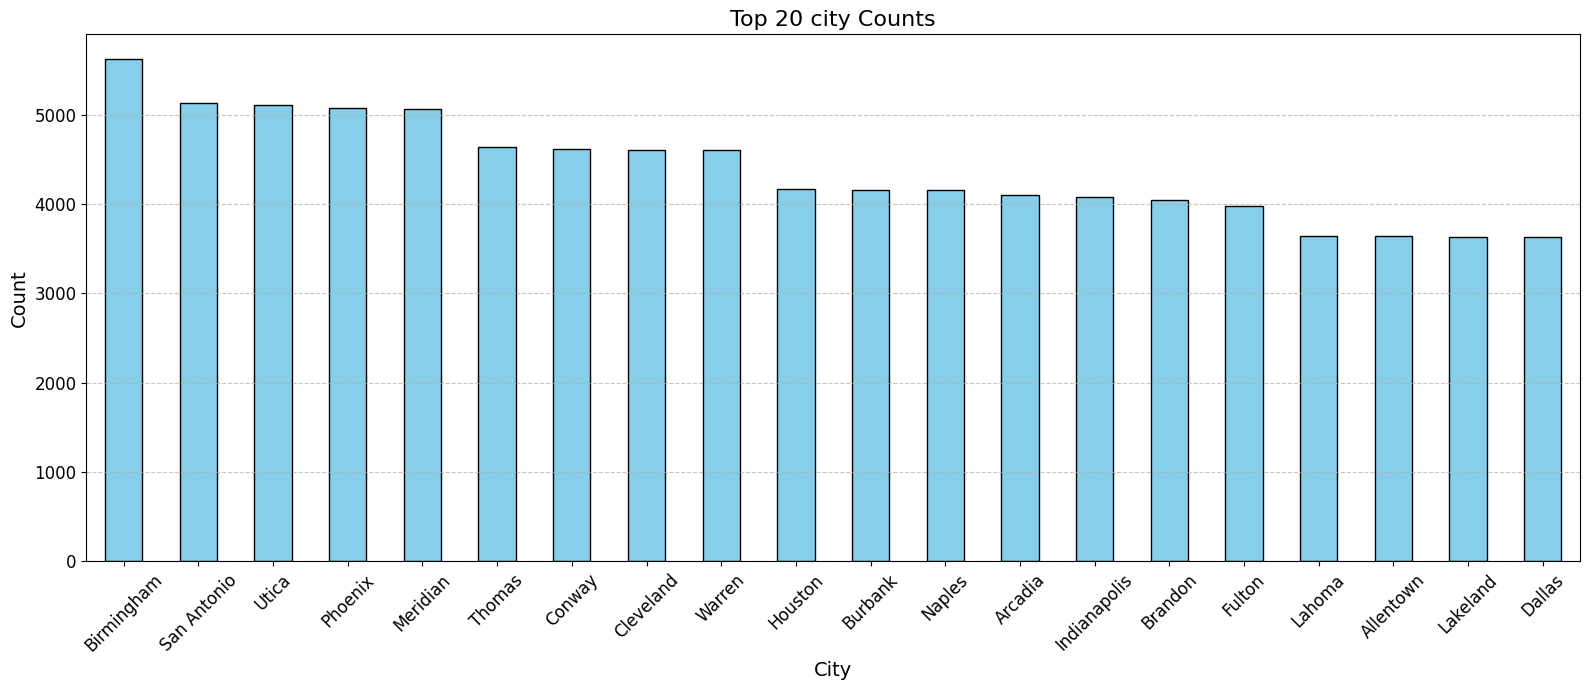

Value counts for 'state':
state
TX    94867
NY    83484
PA    79813
CA    56345
OH    46480
MI    46137
IL    43245
FL    42671
AL    40989
MO    38387
MN    31714
AR    31127
NC    30250
WI    29359
VA    29234
SC    29190
KY    28475
IN    27565
IA    26985
OK    26671
MD    26193
GA    26063
WV    25691
NJ    24603
NE    24168
KS    22987
MS    21181
LA    20965
WY    19322
WA    18924
OR    18597
TN    17547
ME    16496
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT    11754
AZ    10770
UT    10699
NH     8278
CT     7702
NV     5599
ID     5545
DC     3613
HI     2559
AK     2120
RI      550
Name: count, dtype: int64 



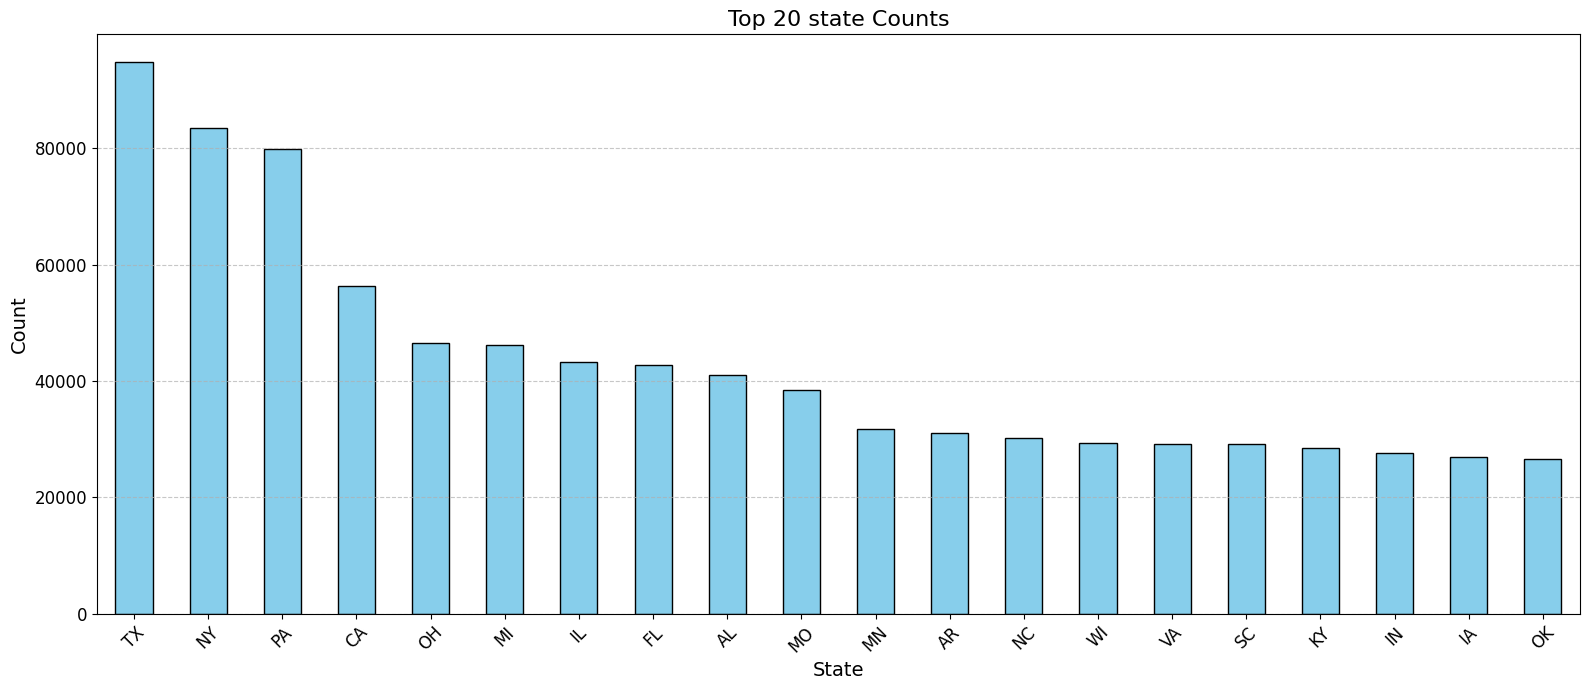

Value counts for 'job':
job
Film/video editor           9778
Exhibition designer         9198
Naval architect             8684
Surveyor, land/geomatics    8679
Materials engineer          8270
                            ... 
Personnel officer             12
Accountant, chartered         11
Homeopath                     11
Solicitor                     11
Industrial buyer              10
Name: count, Length: 485, dtype: int64 



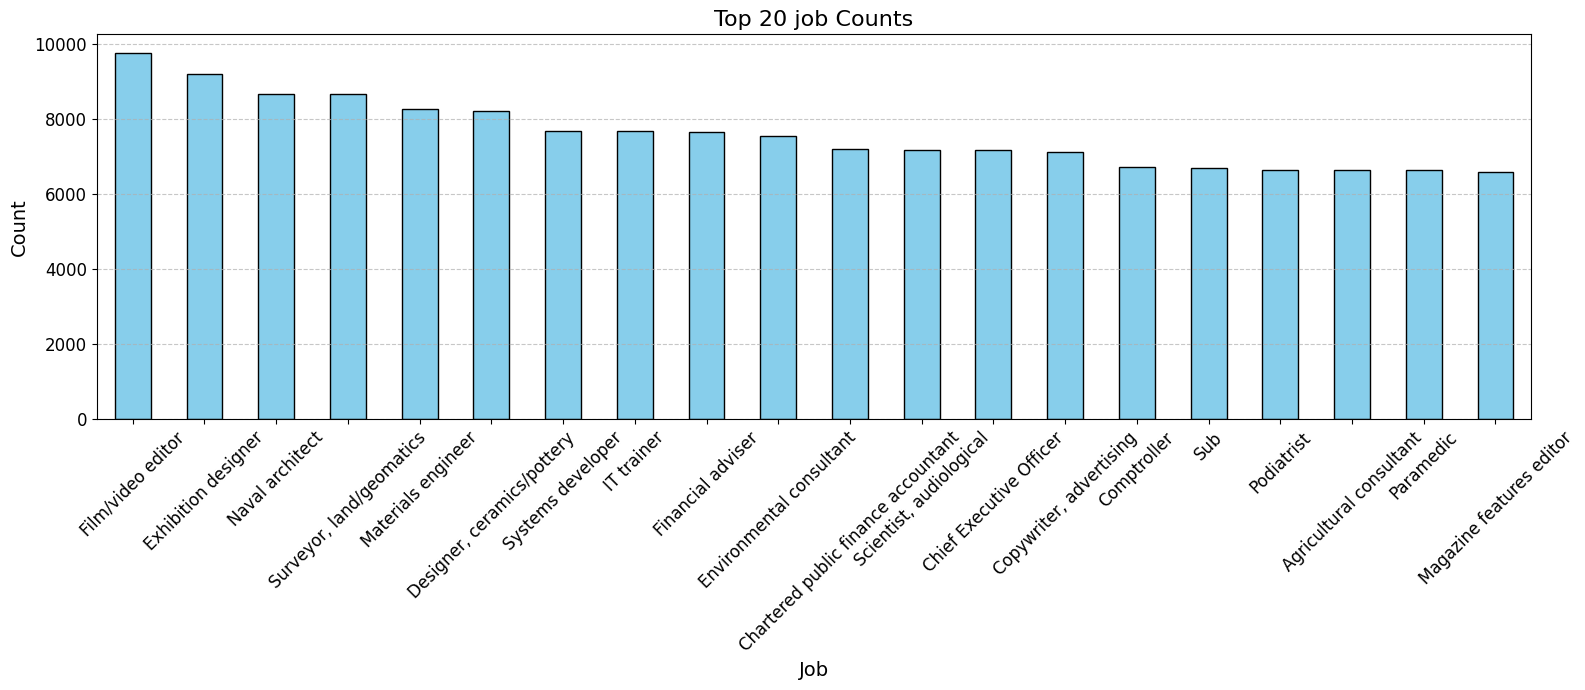

In [54]:
# Function to display all value counts and plot the top 20 counts for columns with >20 unique values
def display_and_plot_counts(df, columns, top_n=20):
    for col in columns:
        # Get value counts for the column
        value_counts = df[col].value_counts()
        # Display the full table of value counts
        print(f"Value counts for '{col}':")
        print(value_counts, "\n")
        # Plot the top N counts if there are more than N unique values
        if len(value_counts) > top_n:
            plt.figure(figsize=(16, 7))
            value_counts.head(top_n).plot(kind='bar', color='skyblue', edgecolor='black')
            plt.title(f'Top {top_n} {col} Counts', fontsize=16)
            plt.xlabel(col.capitalize(), fontsize=14)
            plt.ylabel('Count', fontsize=14)
            plt.xticks(rotation=45, fontsize=12)
            plt.yticks(fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
# Apply the function to the selected columns
columns_to_plot = ['city', 'state', 'job']
display_and_plot_counts(credit_card_df, columns_to_plot)

In [55]:
numerical_fields = credit_card_df.select_dtypes(include=['number']).columns
print(f'Numeric columns in the dataset:{numerical_fields}')
categorical_fields = credit_card_df.select_dtypes(include=['object']).columns
print(f'Categorical columns in the dataset:{categorical_fields}')

Numeric columns in the dataset:Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long', 'month',
       'day', 'hour'],
      dtype='object')
Categorical columns in the dataset:Index(['merchant', 'category', 'first', 'last', 'gender', 'street', 'city',
       'state', 'job', 'dob', 'is_fraud', 'age_range', 'weekday'],
      dtype='object')


In [56]:
# Generate descriptive statistics for numerical attributes
numerical_stats = credit_card_df[numerical_fields].describe()
# Display the numerical statistics
print("Descriptive Statistics for Numerical Attributes:")
print(numerical_stats)

Descriptive Statistics for Numerical Attributes:
             cc_num           amt           zip      city_pop     merch_lat  \
count  1.296455e+06  1.296455e+06  1.296455e+06  1.296455e+06  1.296455e+06   
mean   4.171524e+17  7.030043e+01  4.880184e+04  9.012709e+04  3.853727e+01   
std    1.308754e+18  1.588715e+02  2.689315e+04  4.807540e+05  5.110023e+00   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.300000e+01  1.902779e+01   
25%    1.800429e+14  9.900000e+00  2.623700e+04  7.430000e+02  3.473320e+01   
50%    3.521417e+15  4.922000e+01  4.817400e+04  2.456000e+03  3.936567e+01   
75%    4.642255e+15  8.310000e+01  7.204200e+04  2.032800e+04  4.195722e+01   
max    4.992346e+18  2.894890e+04  9.978300e+04  2.504700e+08  6.751027e+01   

         merch_long         month           day          hour  
count  1.296455e+06  1.296455e+06  1.296455e+06  1.296455e+06  
mean  -9.022708e+01  6.142203e+00  1.558794e+01  1.280456e+01  
std    1.377111e+01  3.417723e+00  8.829134e+00

In [57]:
# Generate frequency tables for categorical attributes
for col in categorical_fields:
    print(f"\nFrequency Table for '{col}':")
    print(credit_card_df[col].value_counts())


Frequency Table for 'merchant':
merchant
Unknown                                 79652
fraud_Kilback LLC                        4402
fraud_Cormier LLC                        3643
fraud_Schumm PLC                         3632
fraud_Kuhn LLC                           3509
                                        ...  
fraud_Douglas, DuBuque and McKenzie       775
fraud_Treutel-King                        775
fraud_Medhurst, Labadie and Gottlieb      759
fraud_Reichert-Weissnat                   753
fraud_Hahn, Douglas and Schowalter        727
Name: count, Length: 647, dtype: int64

Frequency Table for 'category':
category
gas_transport     131615
grocery_pos       123559
home              123093
shopping_pos      116629
kids_pets         113019
shopping_net       97471
no category        94001
food_dining        91443
personal_care      90745
health_fitness     85861
misc_pos           79645
misc_net           63238
grocery_net        45439
travel             40497
NO_CATEGORY          

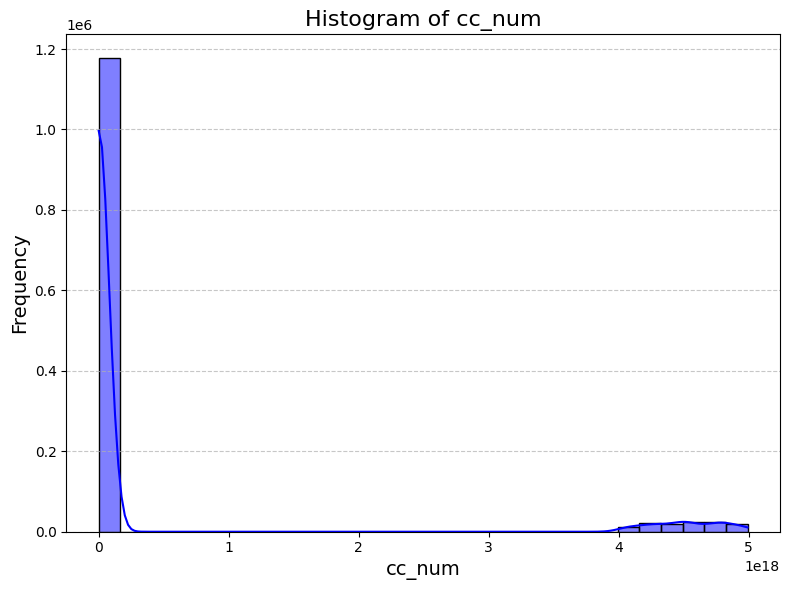

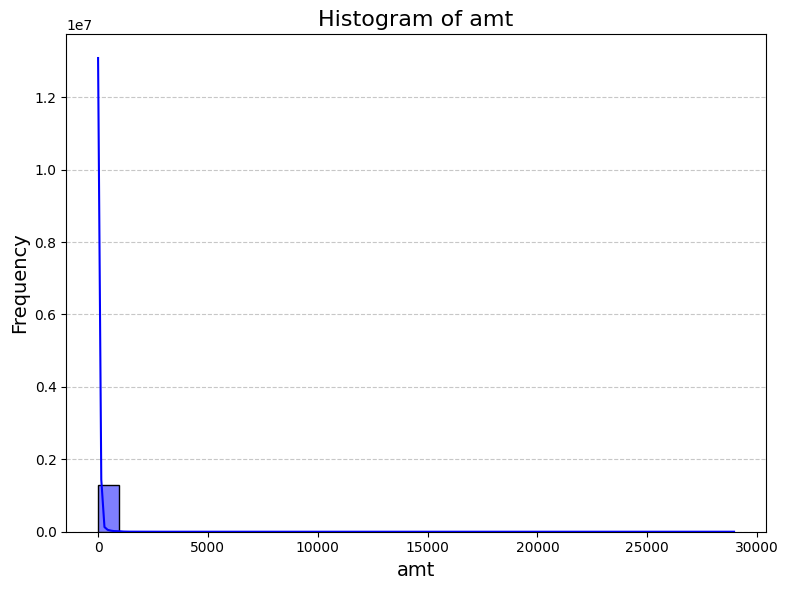

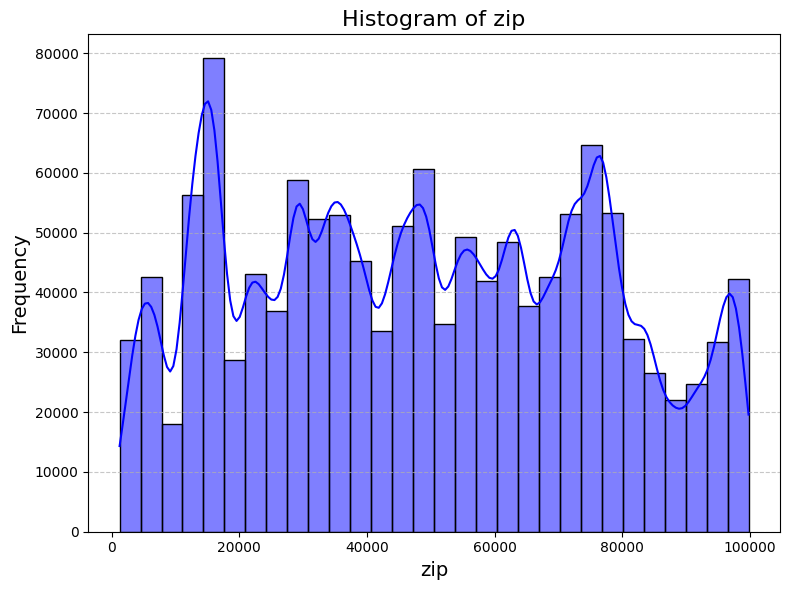

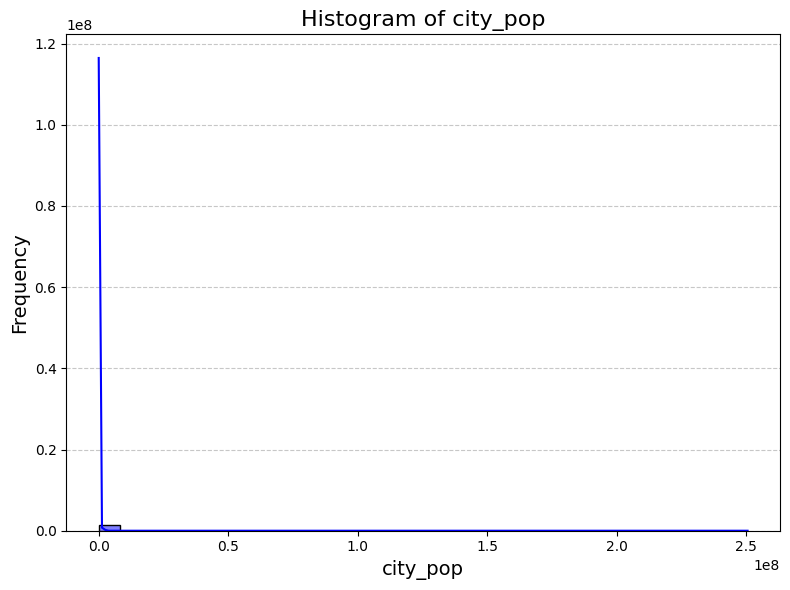

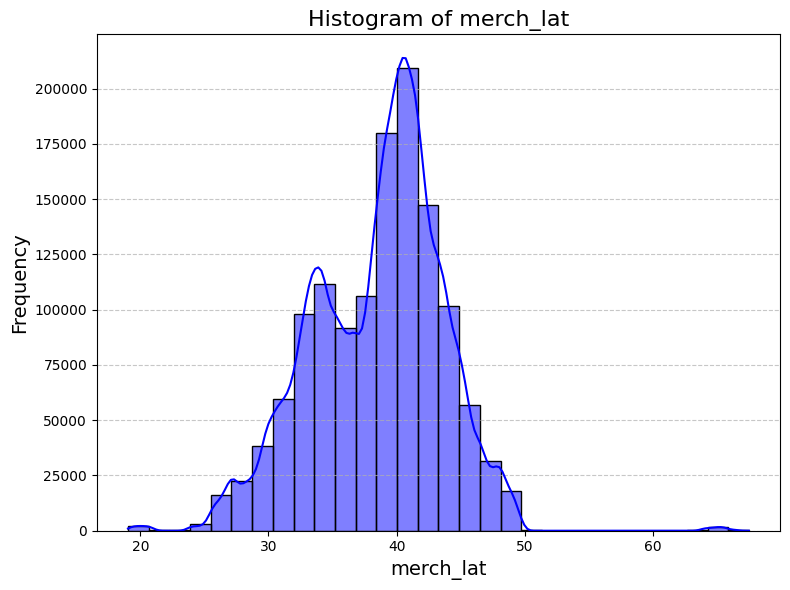

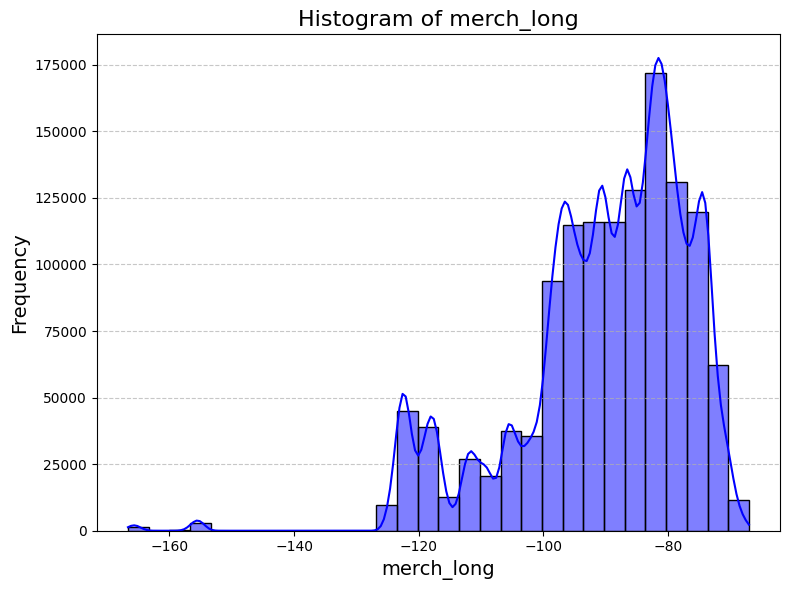

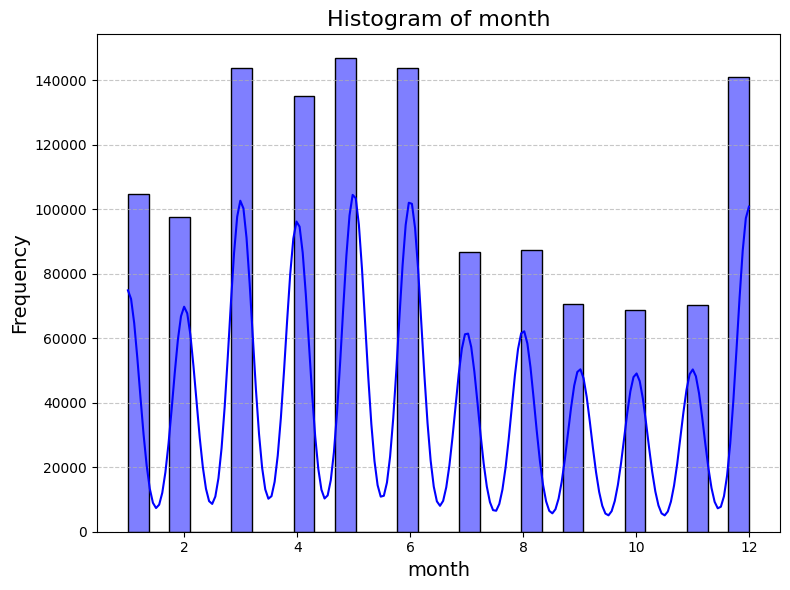

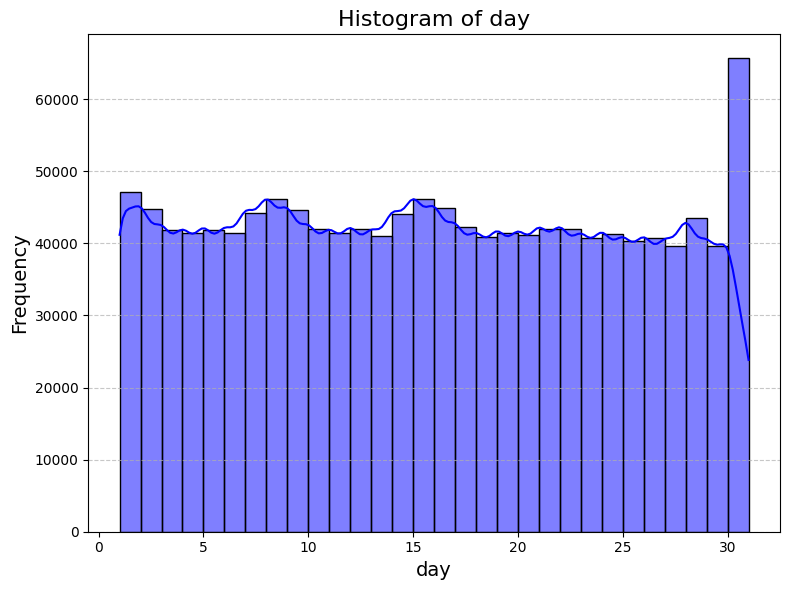

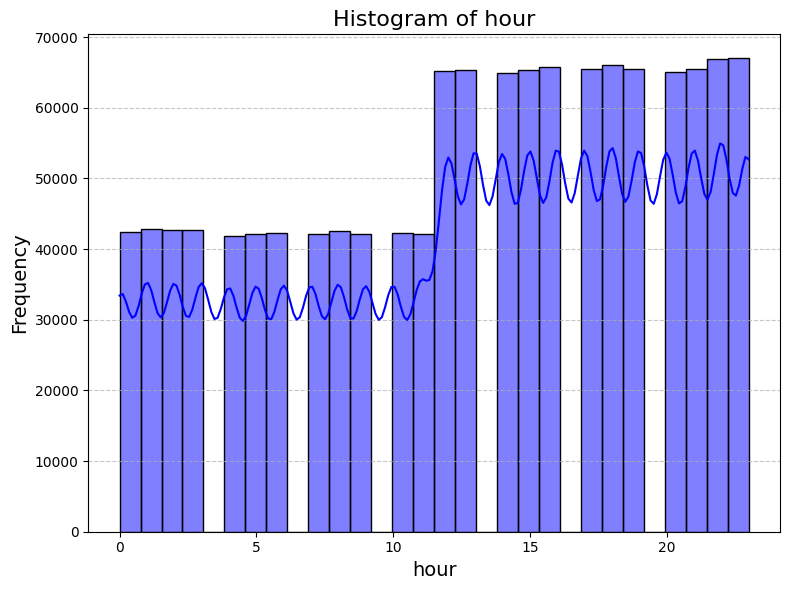

In [58]:
# Plot histograms for numerical attributes
for col in numerical_fields:
    plt.figure(figsize=(8, 6))
    sns.histplot(credit_card_df[col], kde=True, color='blue', bins=30)
    plt.title(f'Histogram of {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

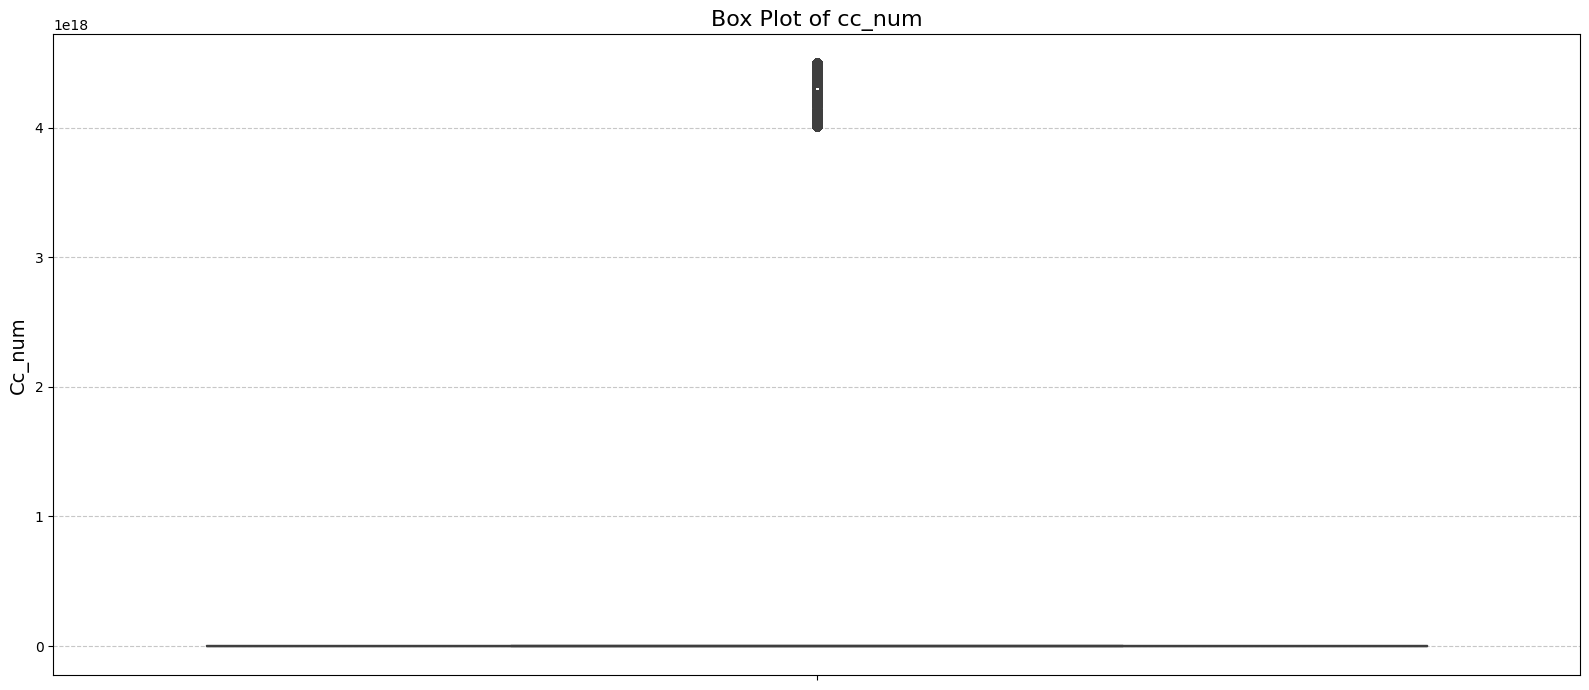

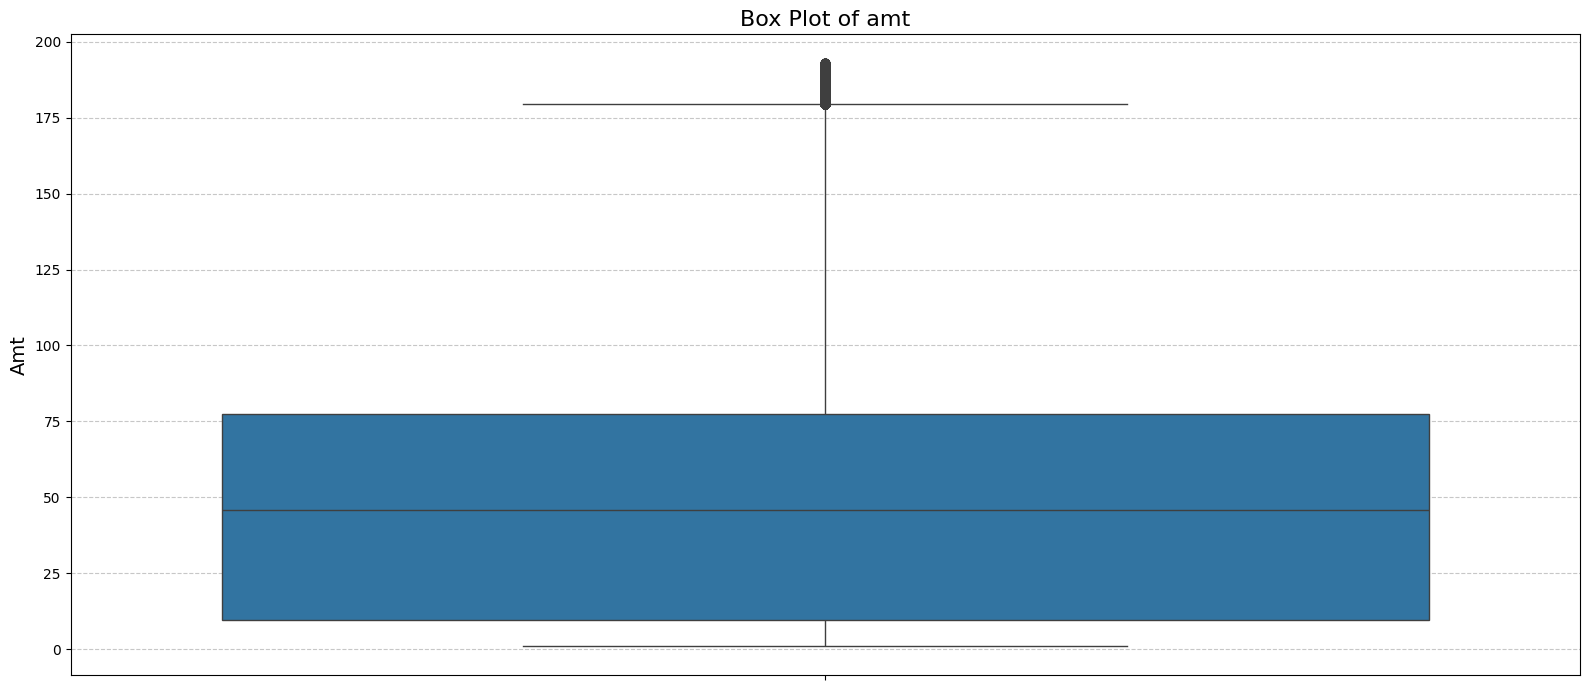

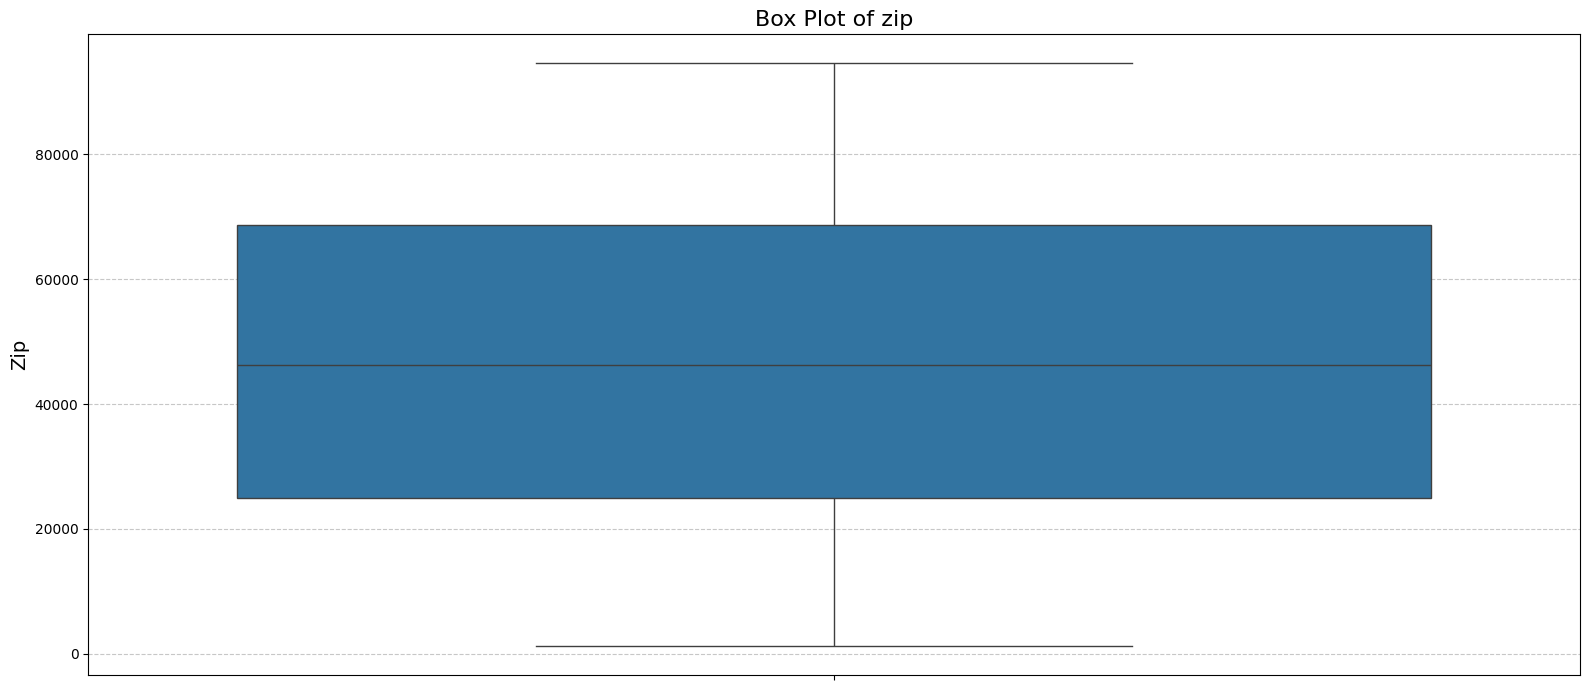

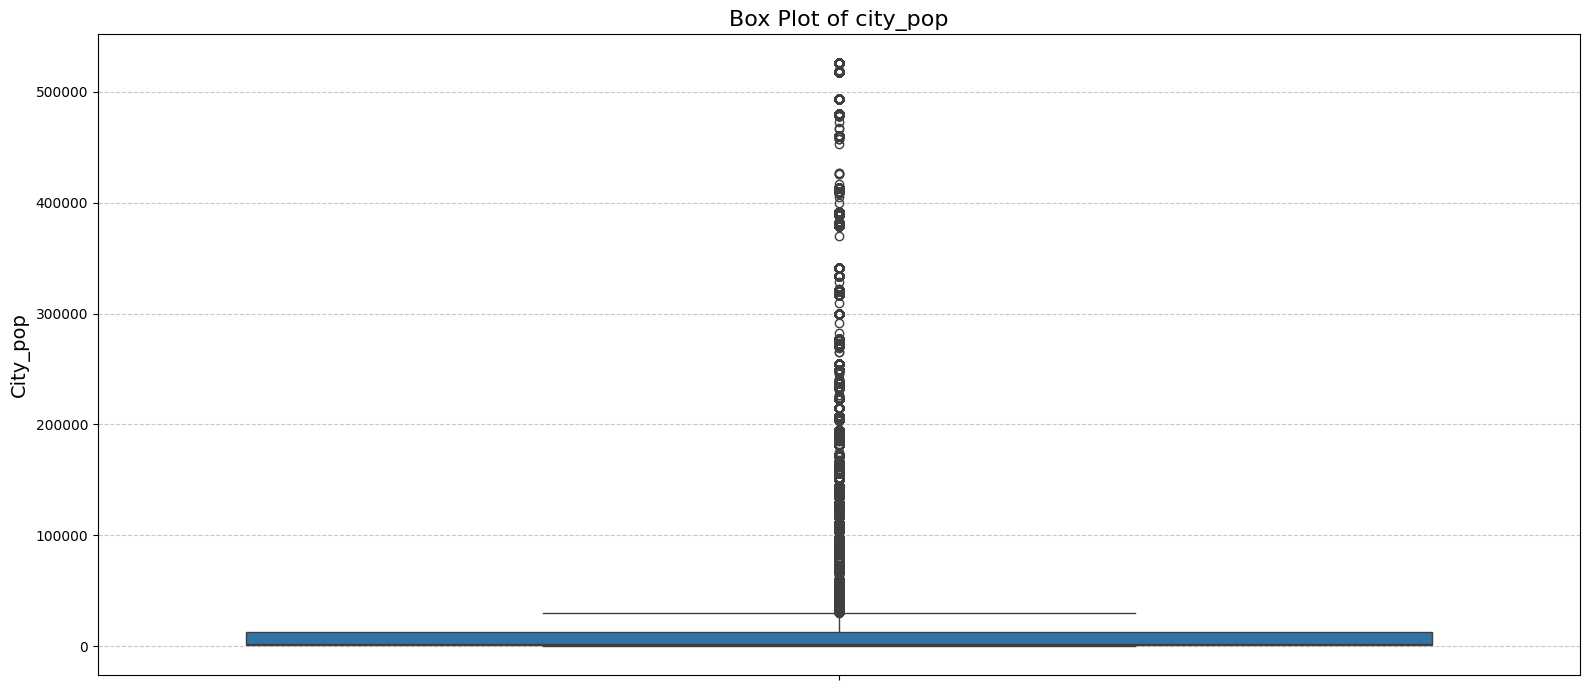

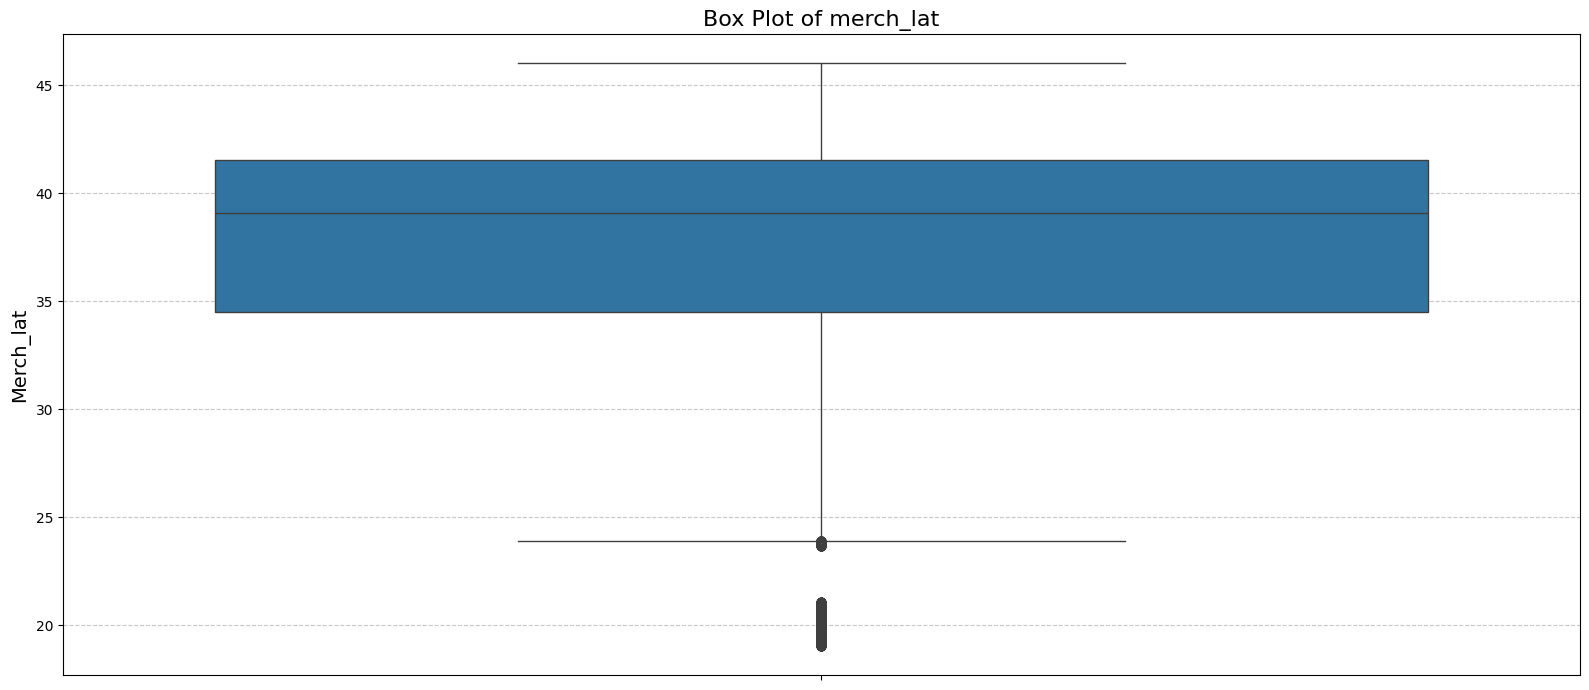

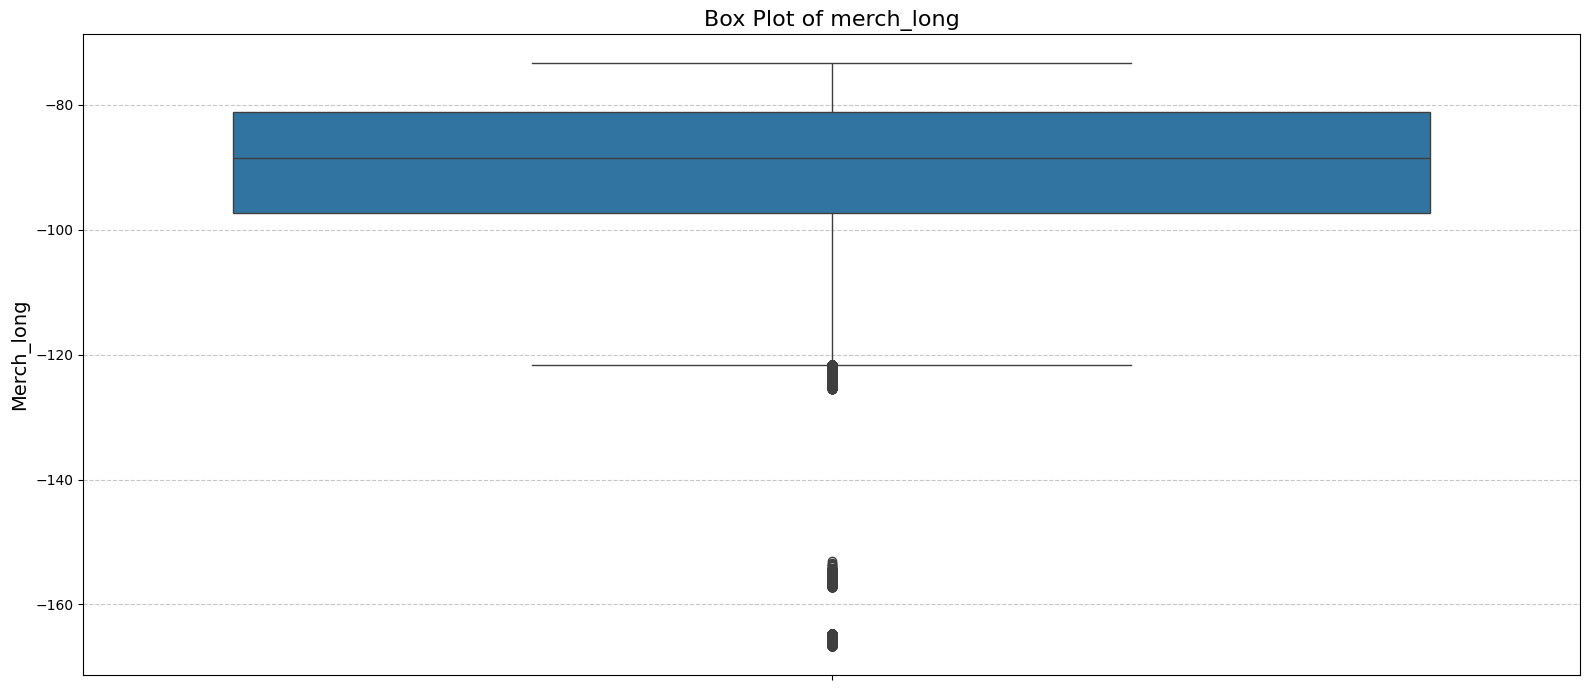

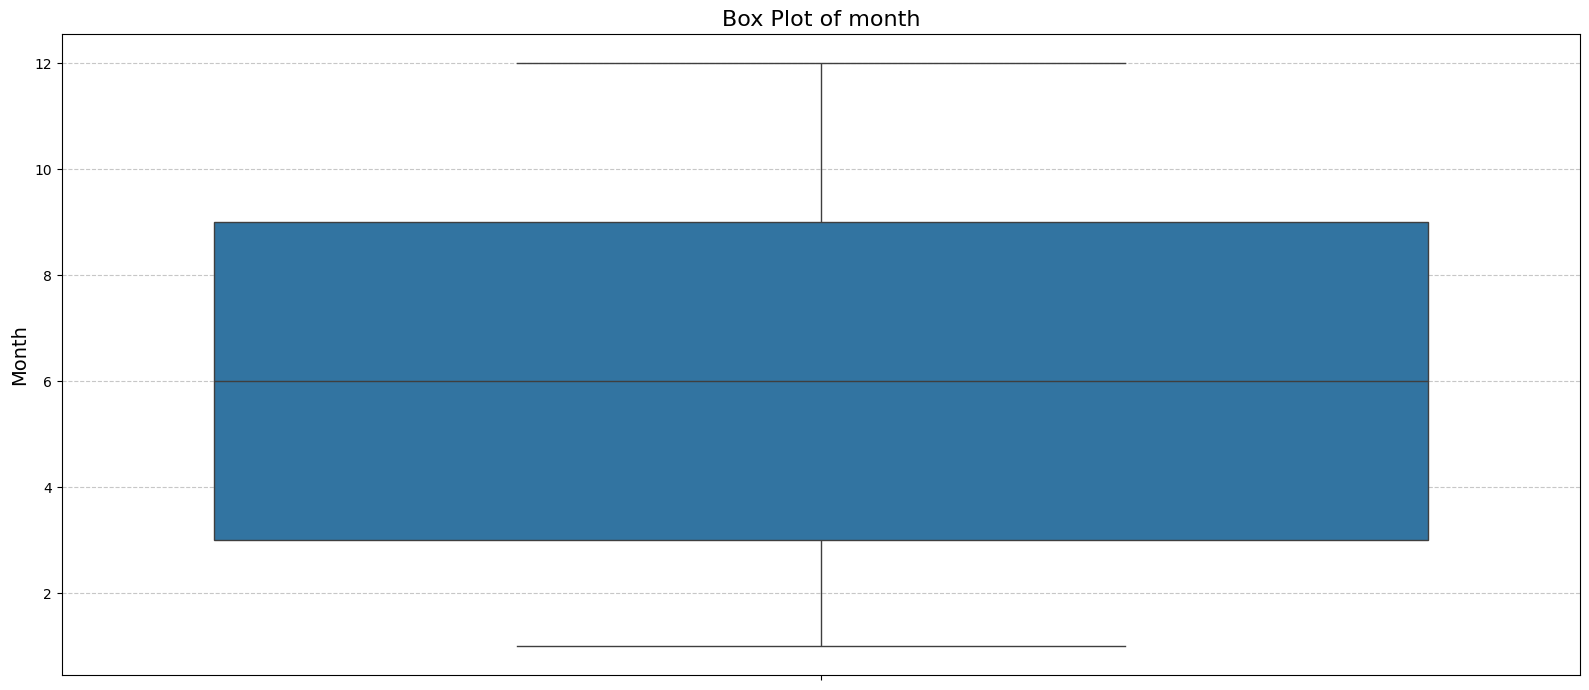

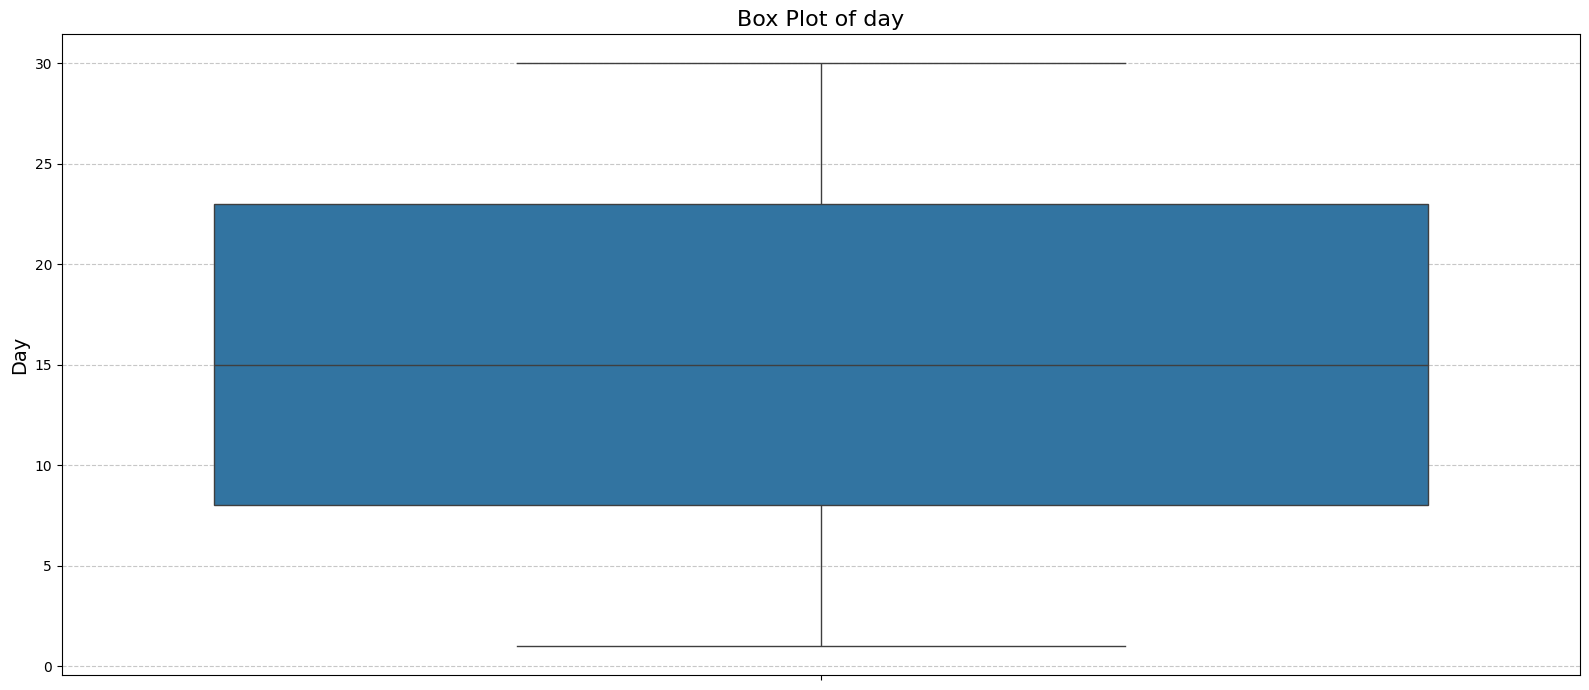

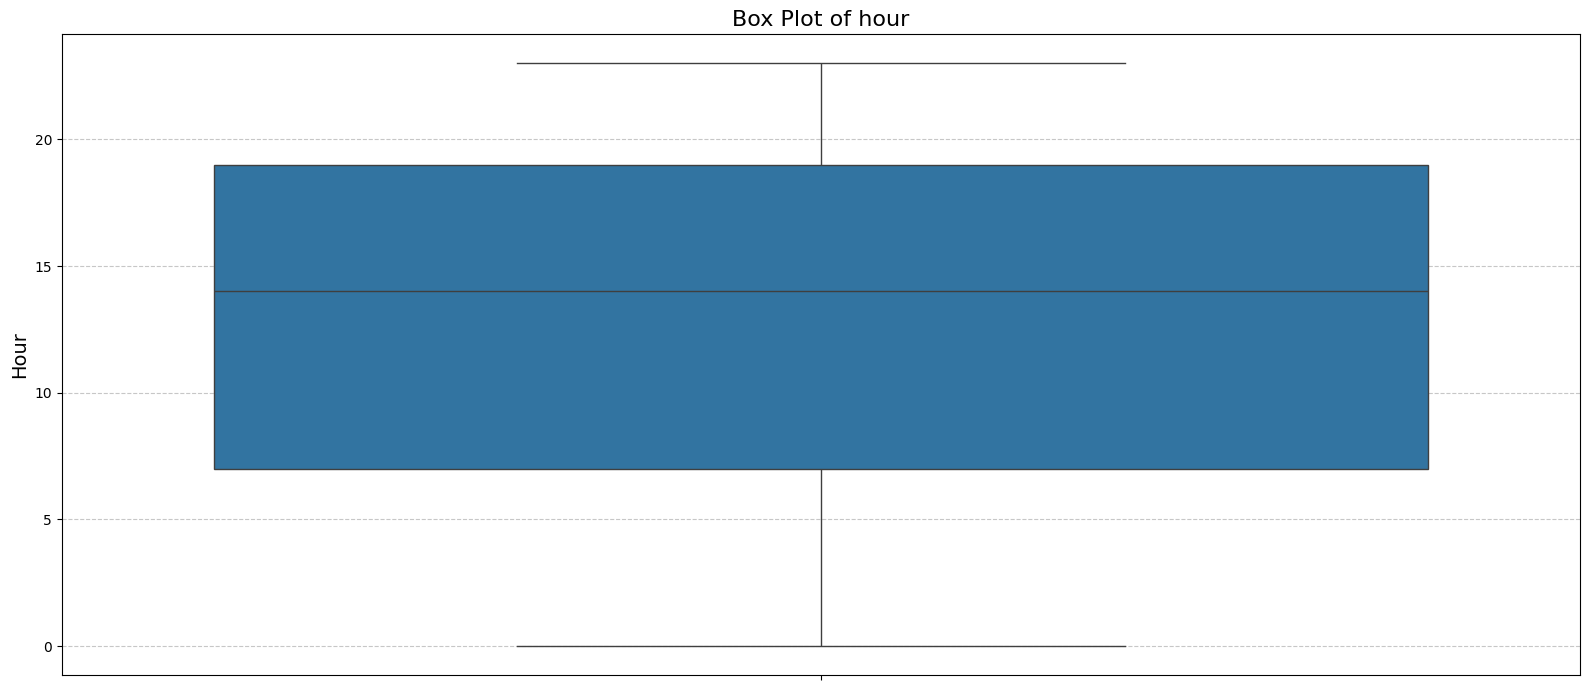

In [59]:
# Generate box plots for individual numerical attributes
for numerical in numerical_fields:
    plt.figure(figsize=(16, 7))
    percentile = credit_card_df[numerical].quantile(0.95)
    filtered_df = credit_card_df[credit_card_df[numerical] <= percentile]
    sns.boxplot(y=numerical, data=filtered_df)
    plt.title(f'Box Plot of {numerical}', fontsize=16)
    plt.ylabel(numerical.capitalize(), fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

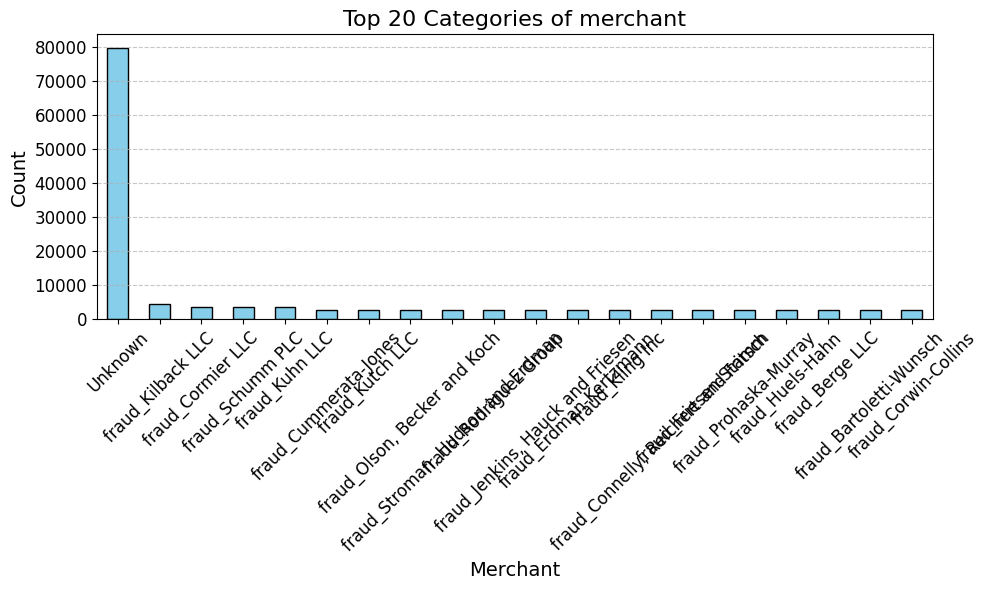

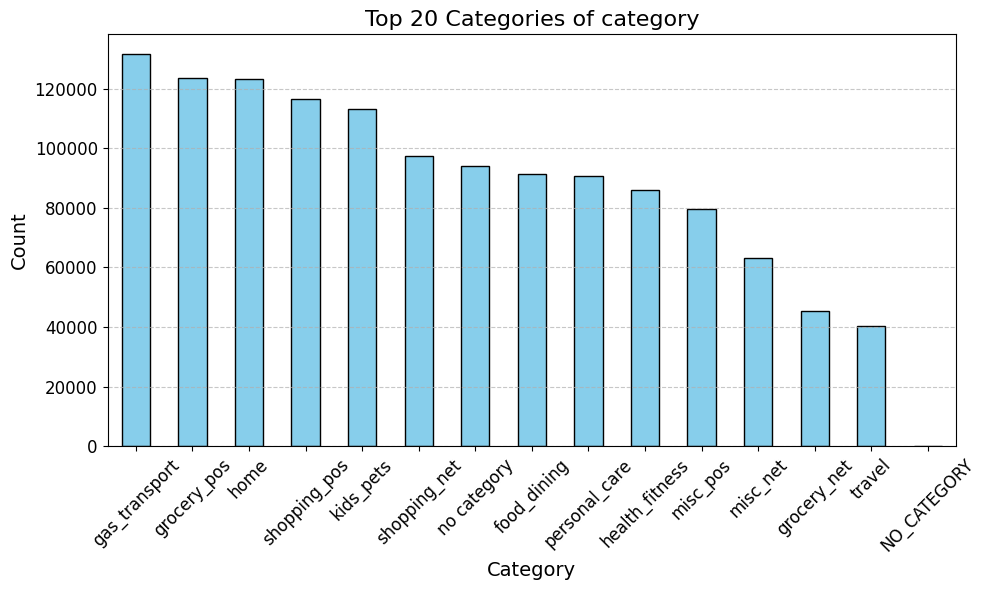

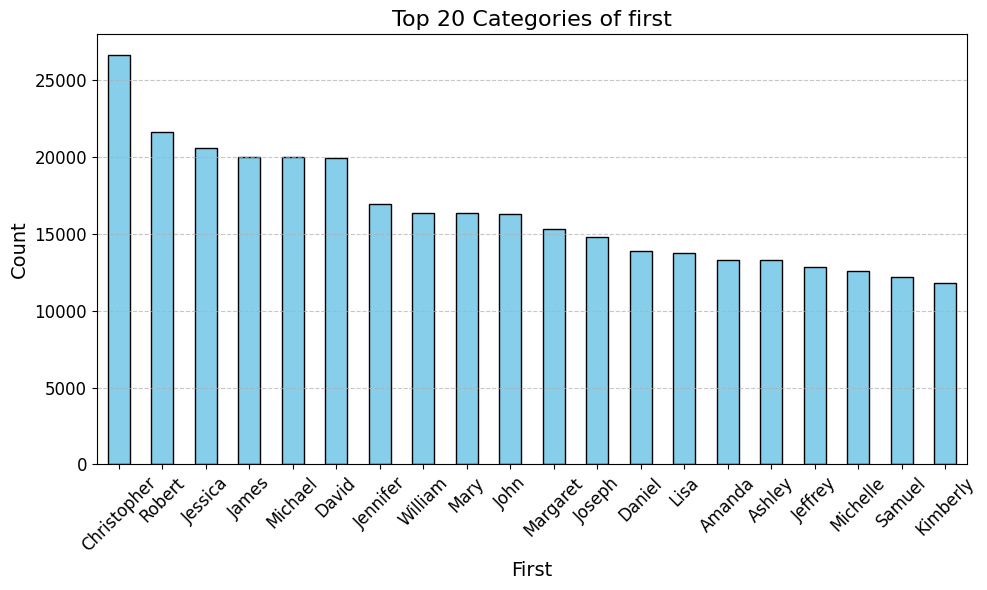

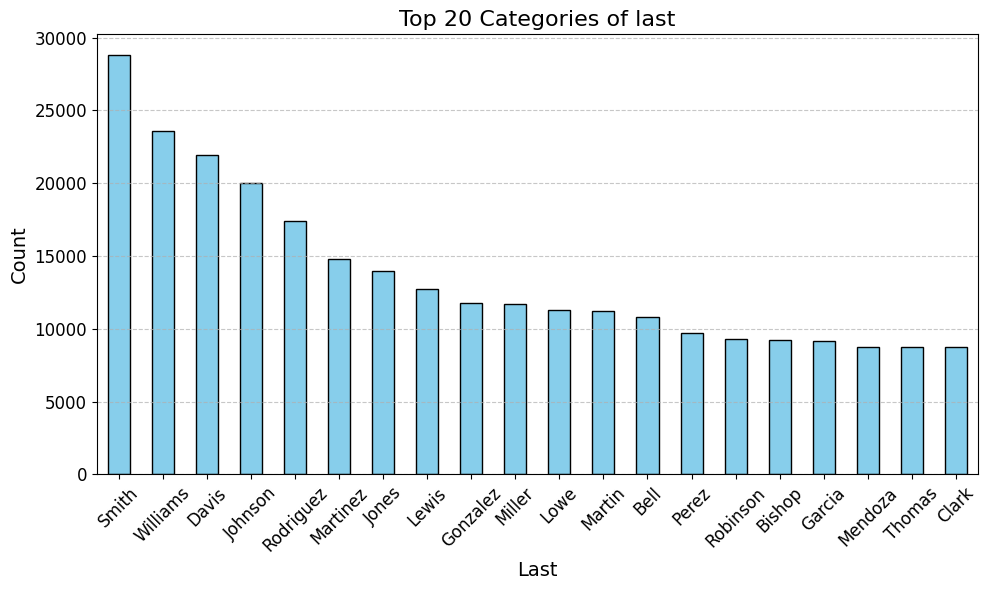

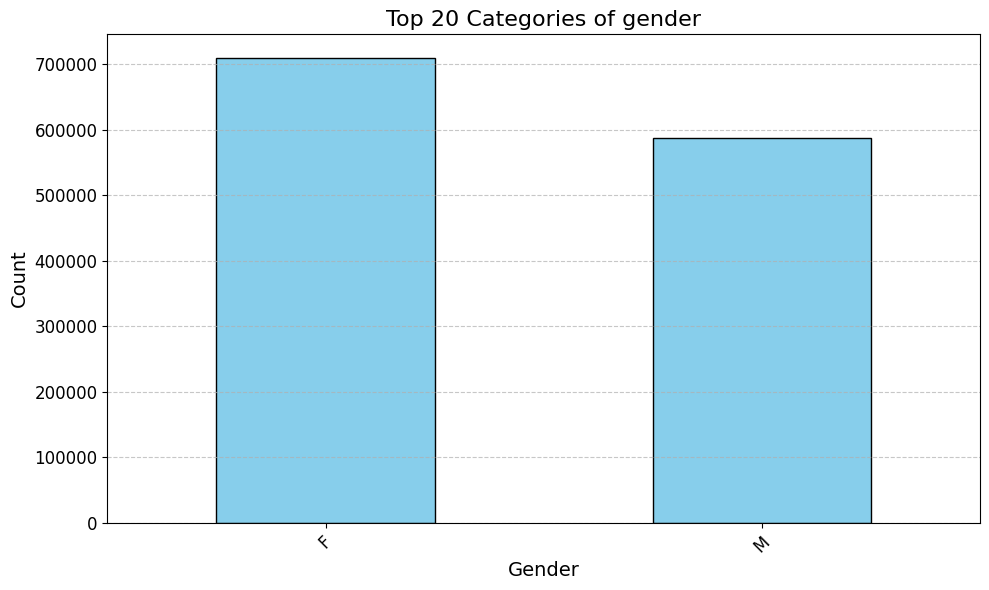

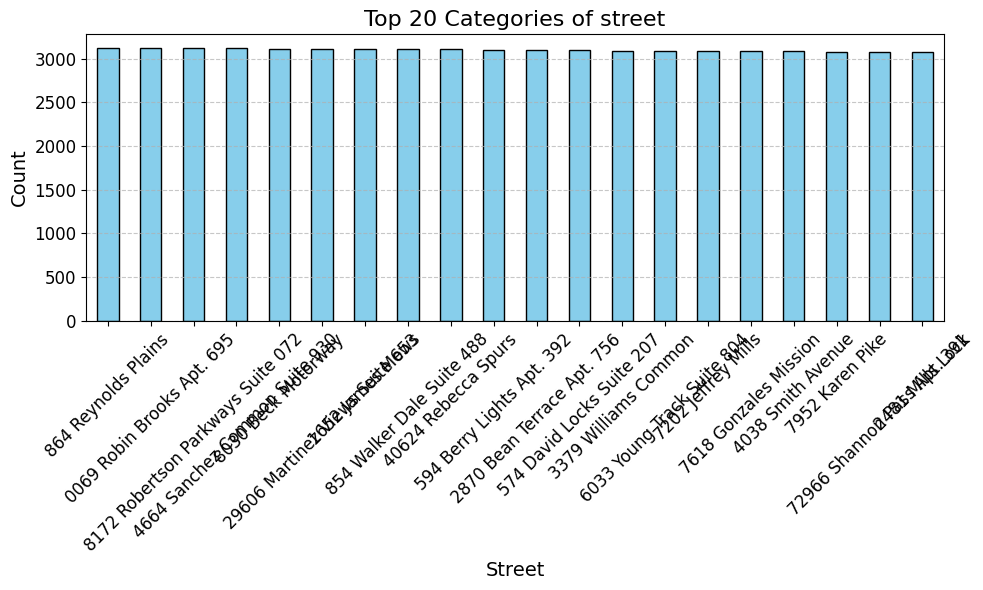

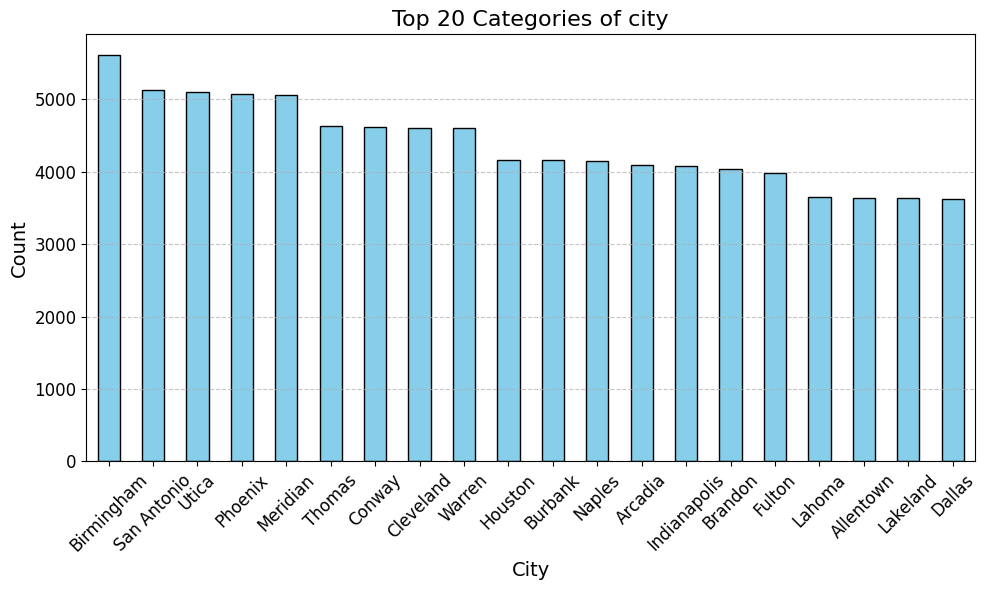

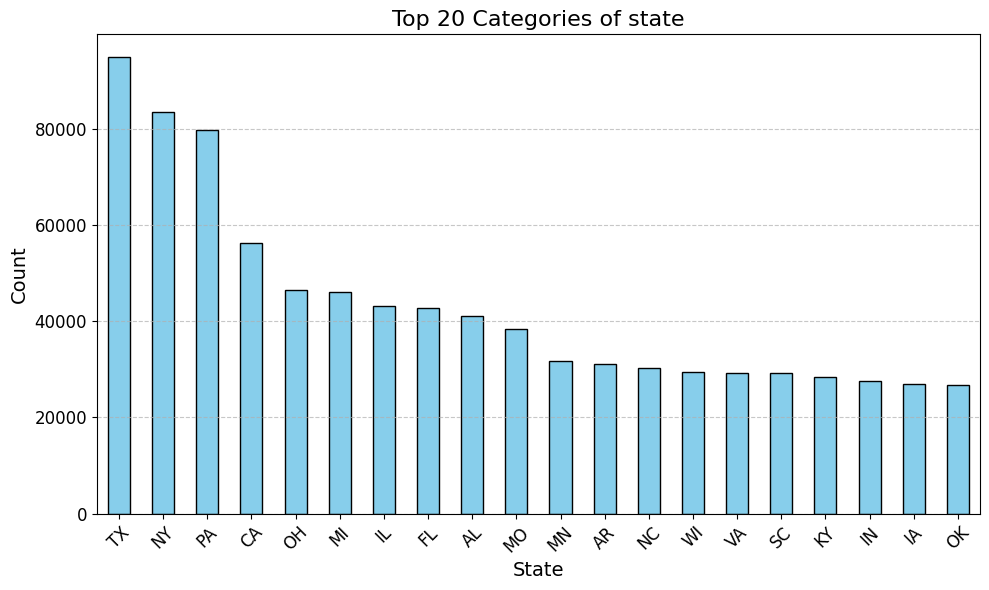

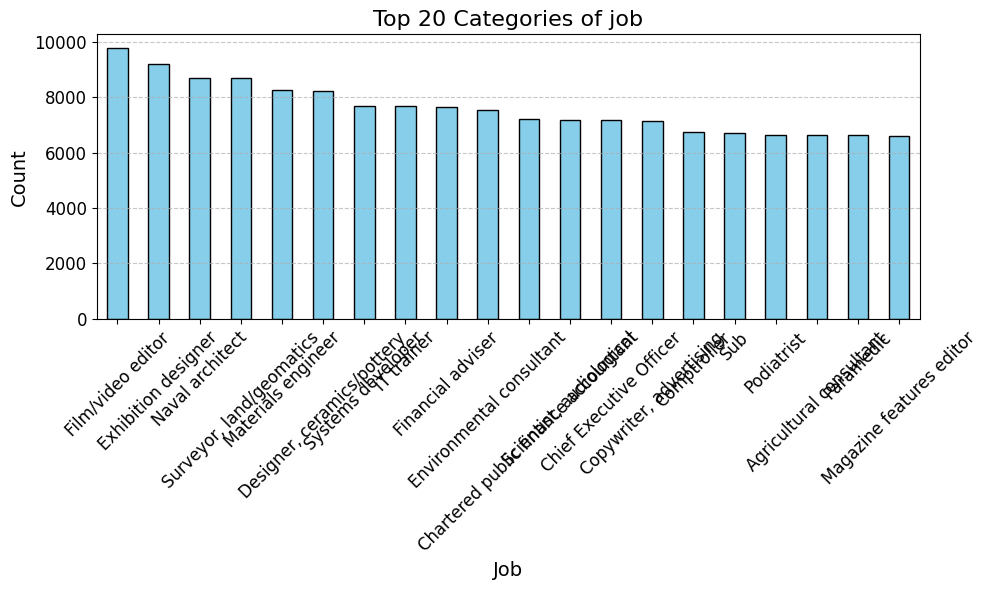

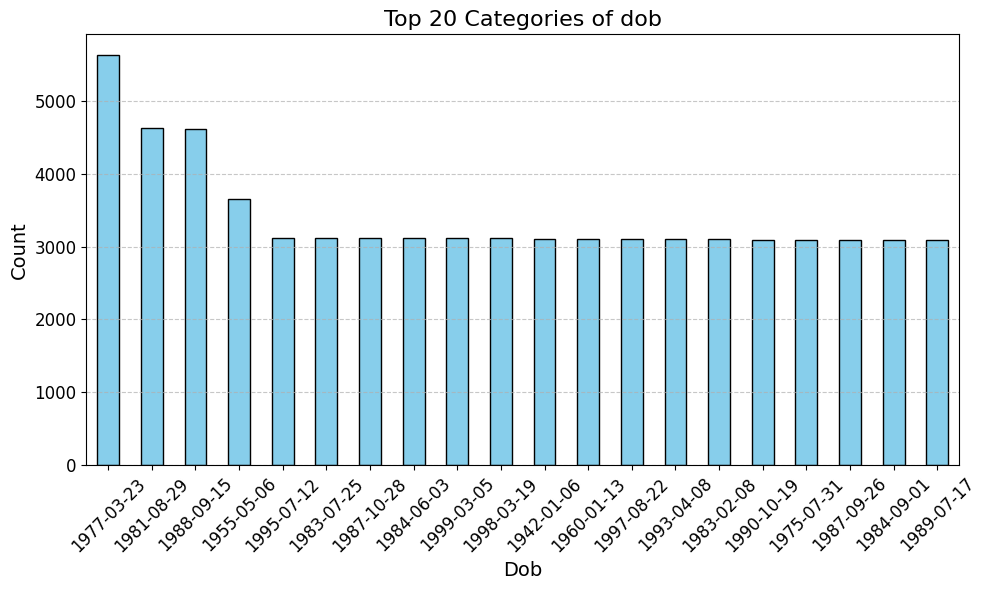

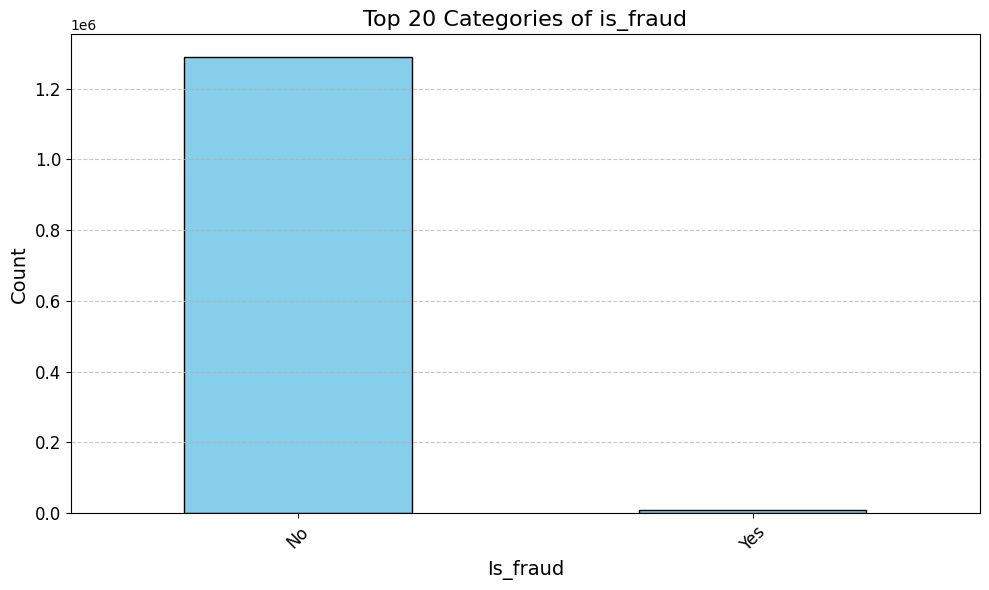

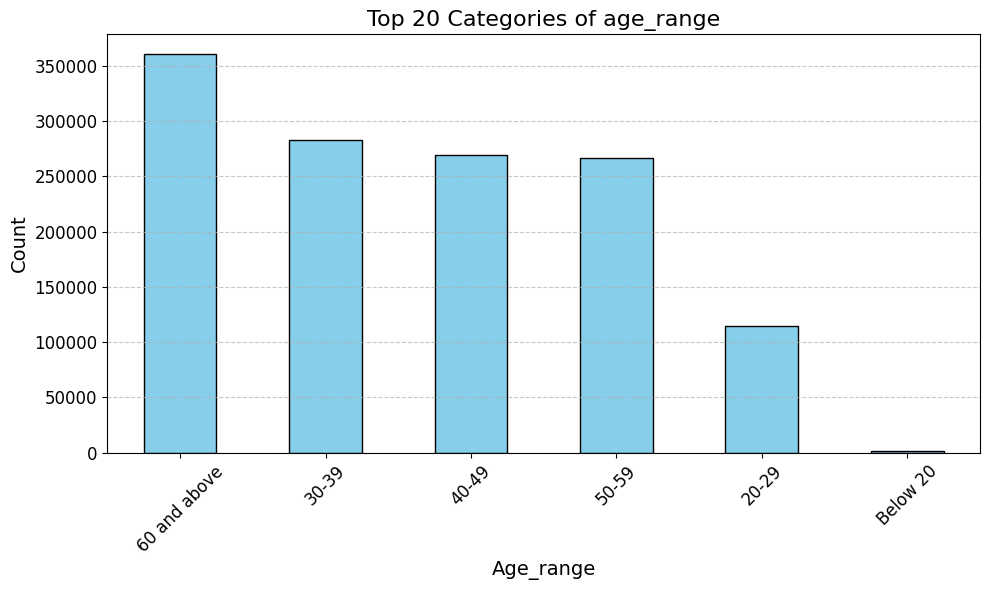

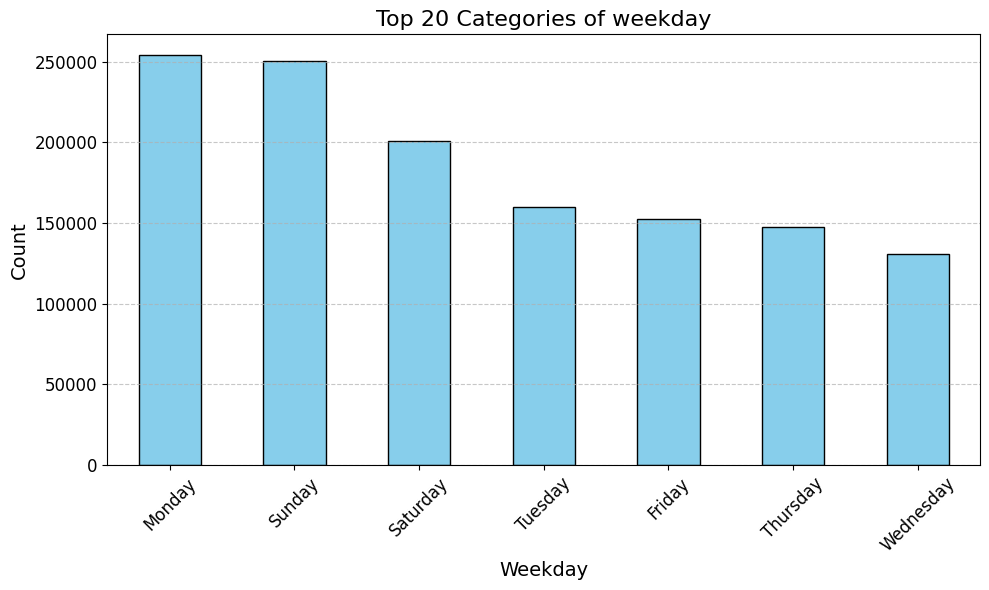

In [60]:
# Plot bar charts for categorical attributes
for col in categorical_fields:
    plt.figure(figsize=(10, 6))
    credit_card_df[col].value_counts().head(20).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Top 20 Categories of {col}', fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Anlytical variable
Here the analytical variable is is_fraud to verify let's see all the polts for the case where it is yes.

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


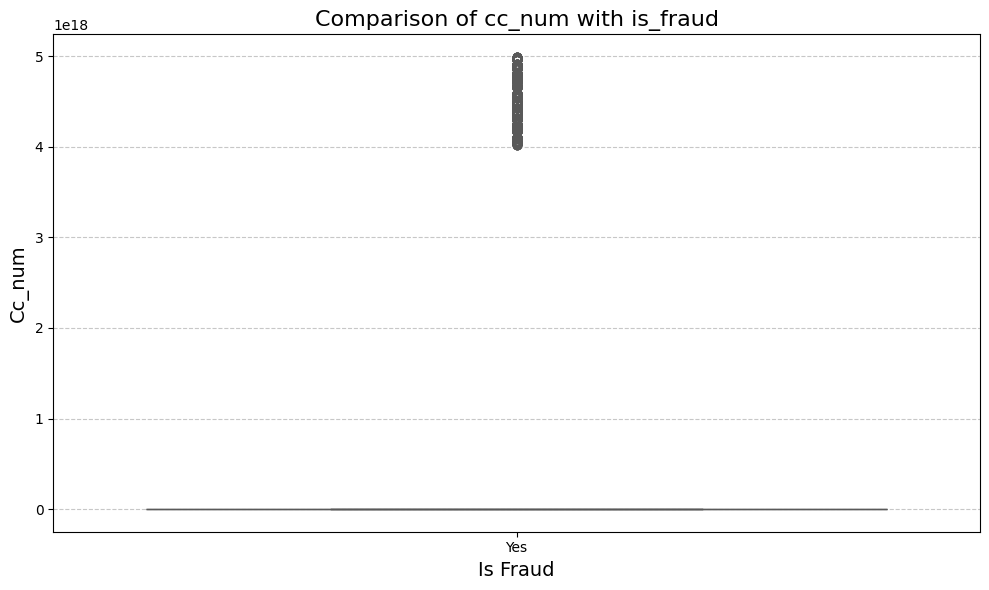

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


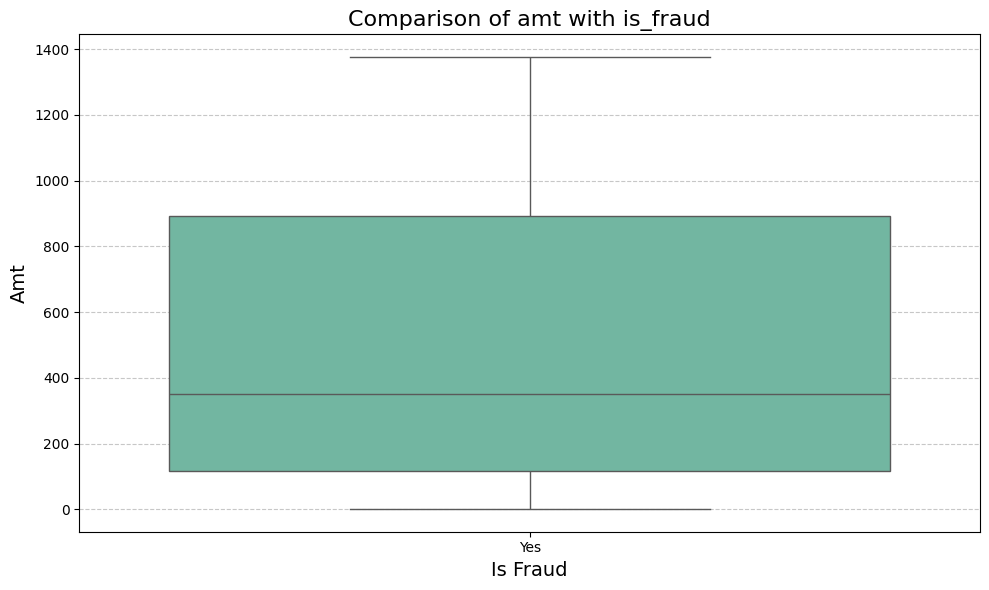

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


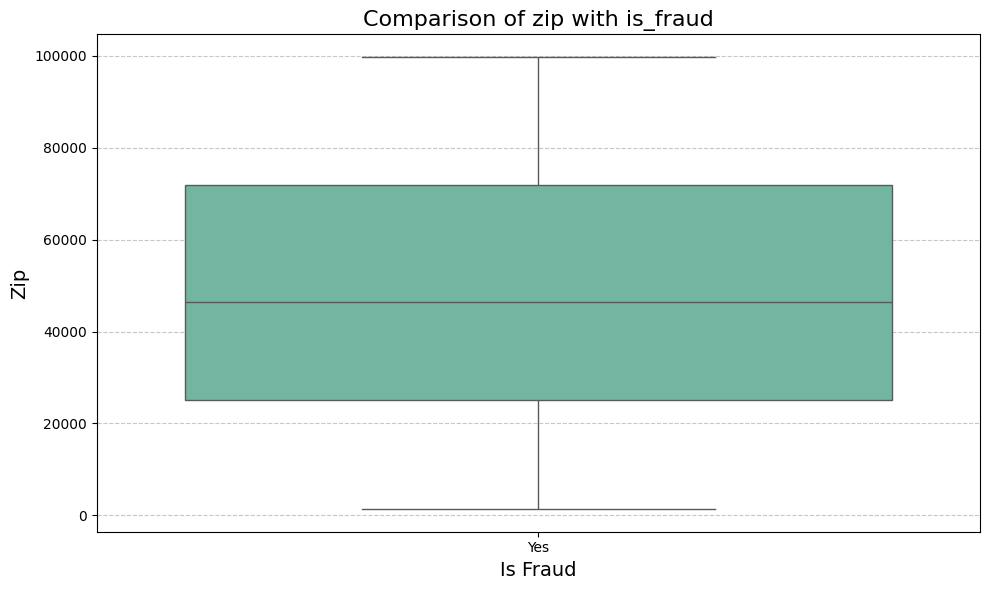

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


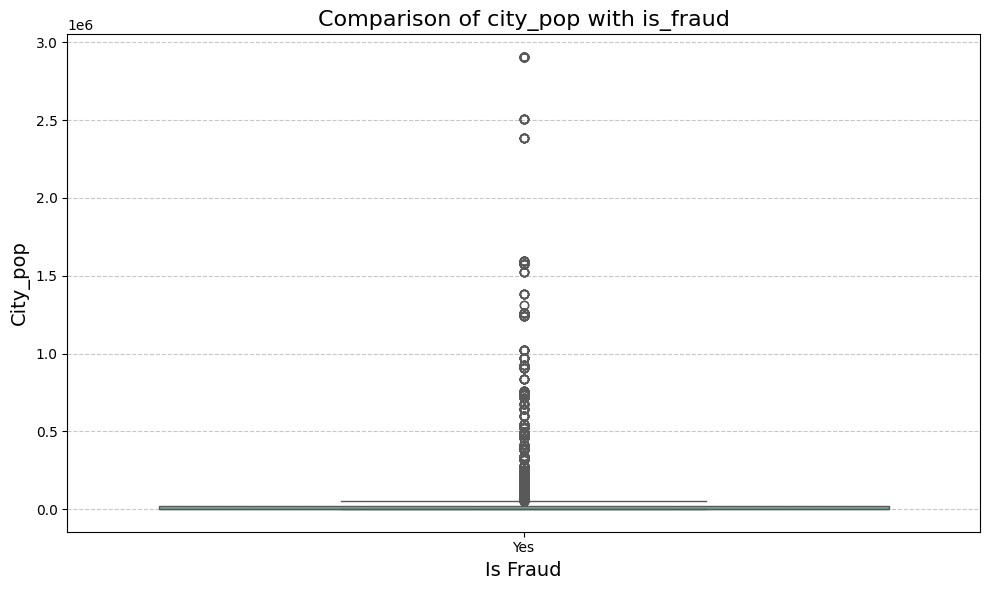

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


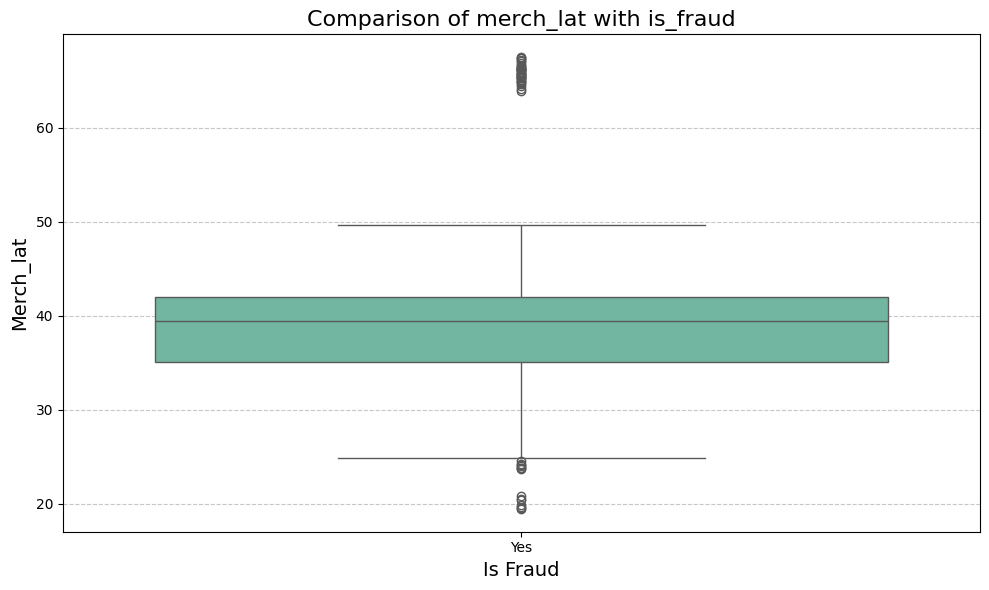

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


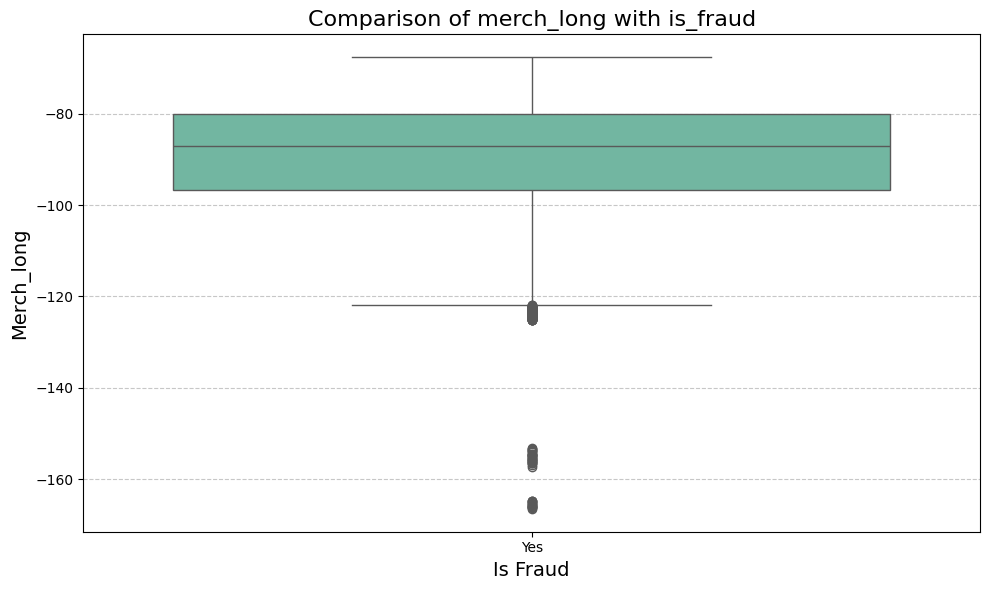

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


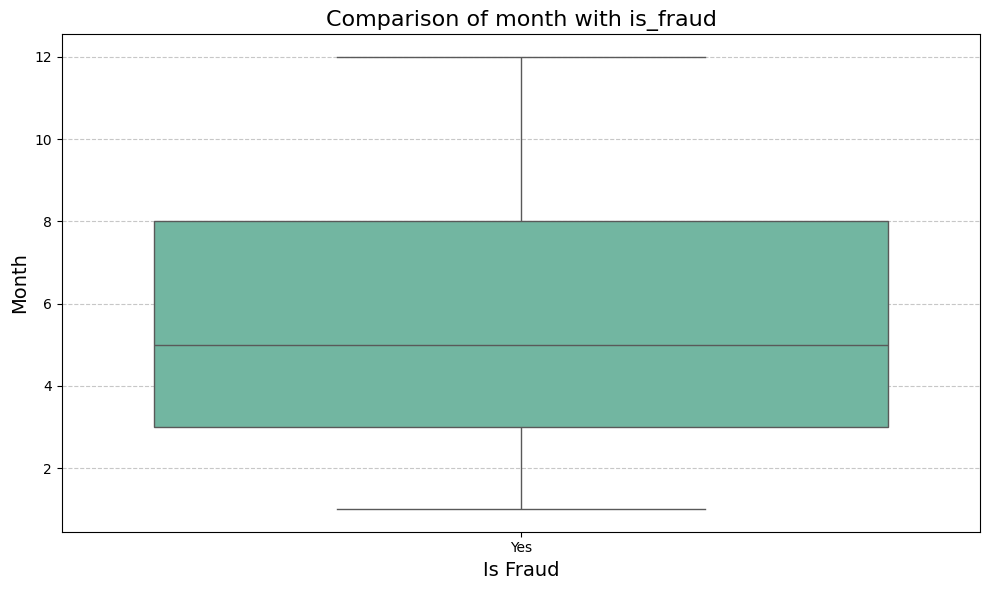

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


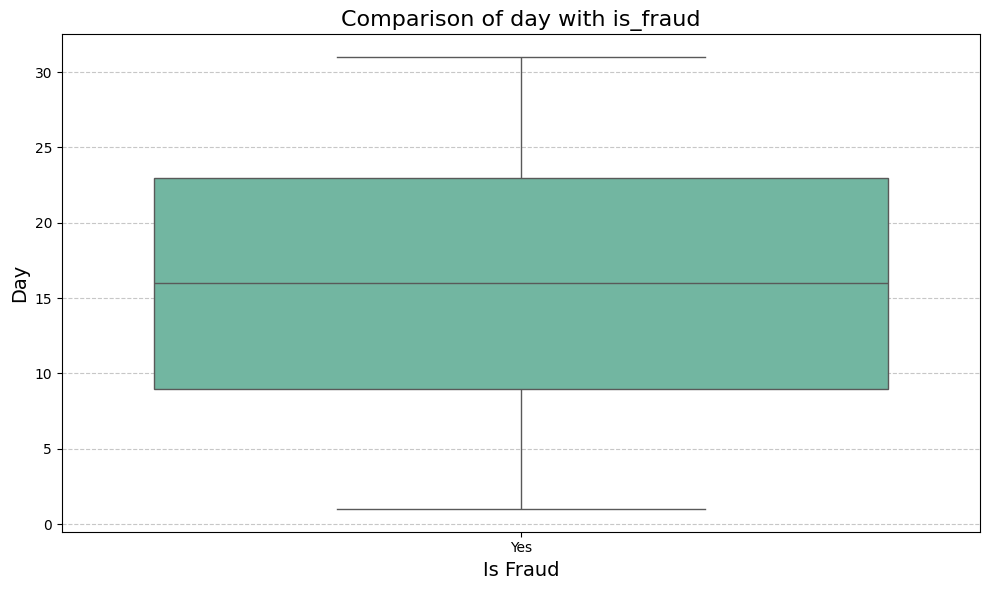

<ipython-input-61-000df7ada372>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')


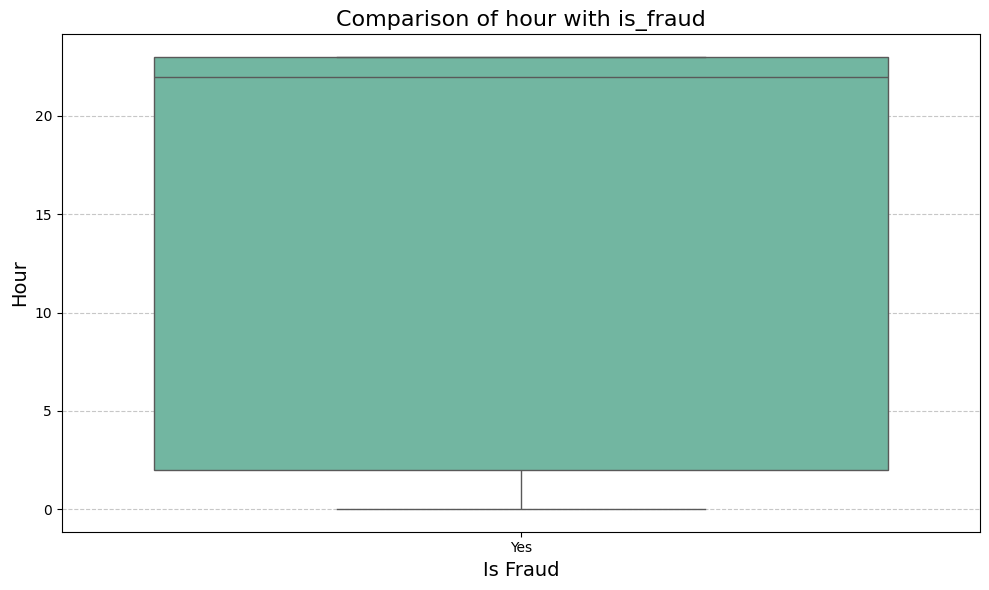

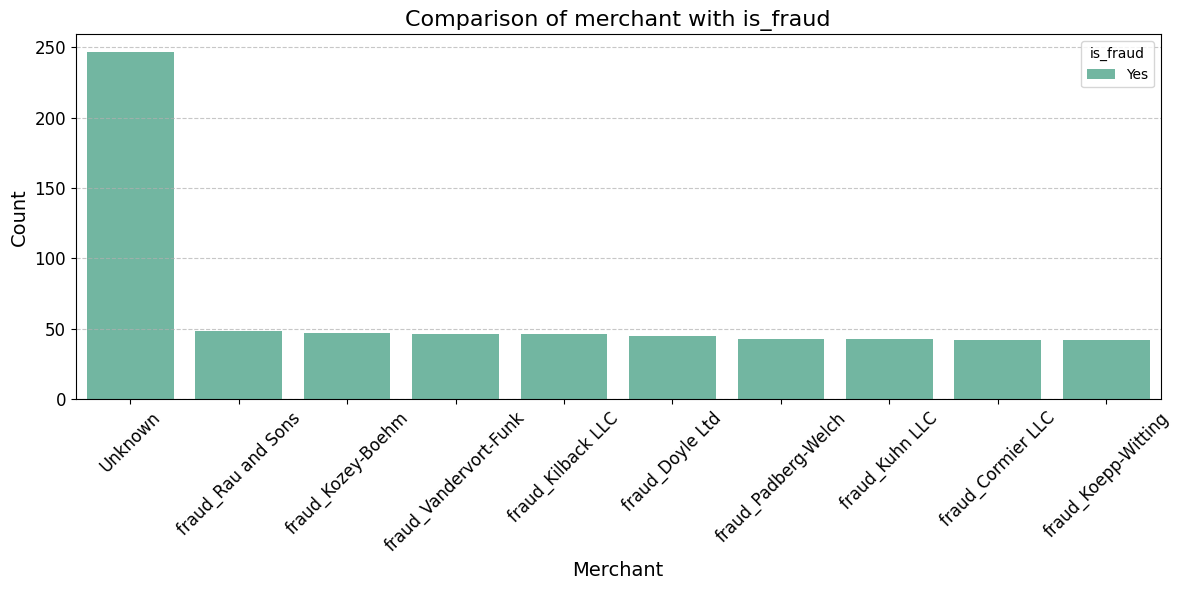

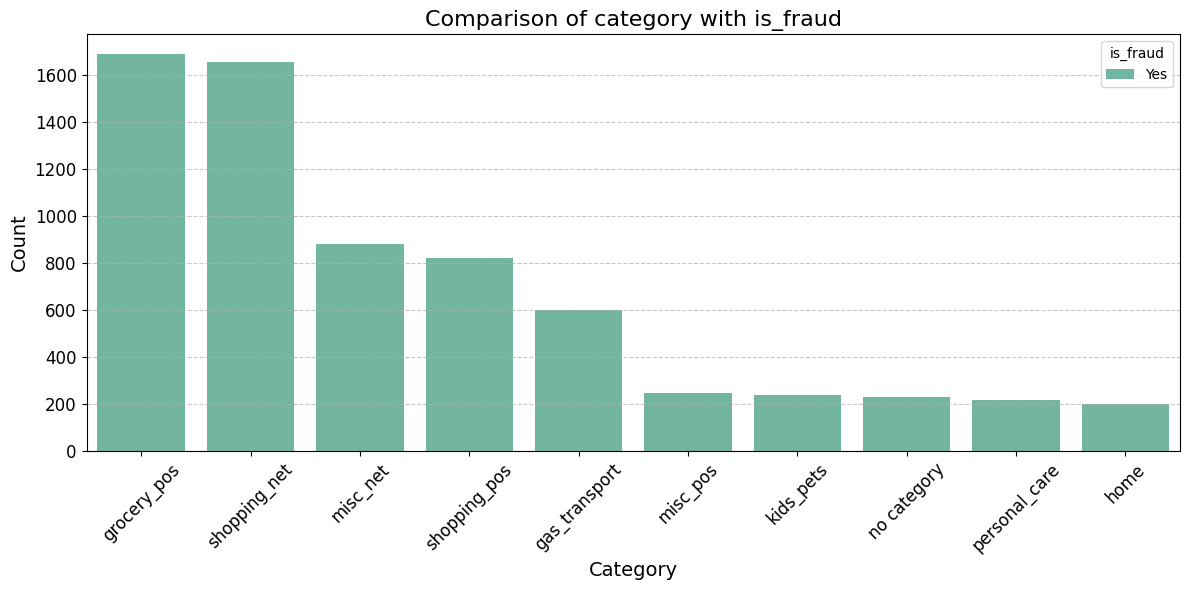

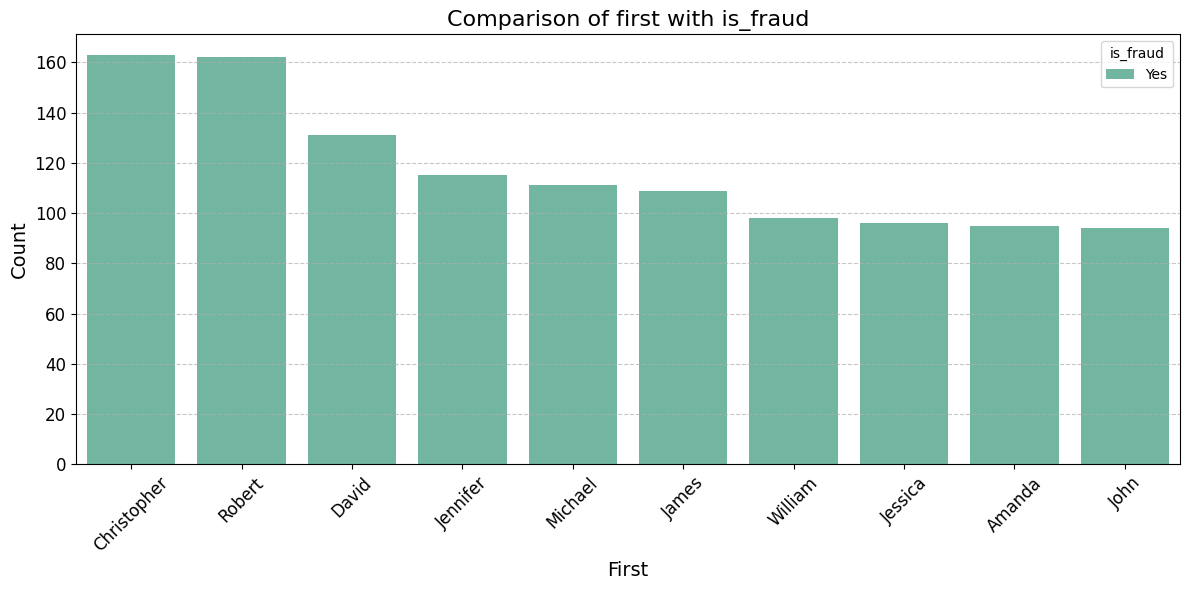

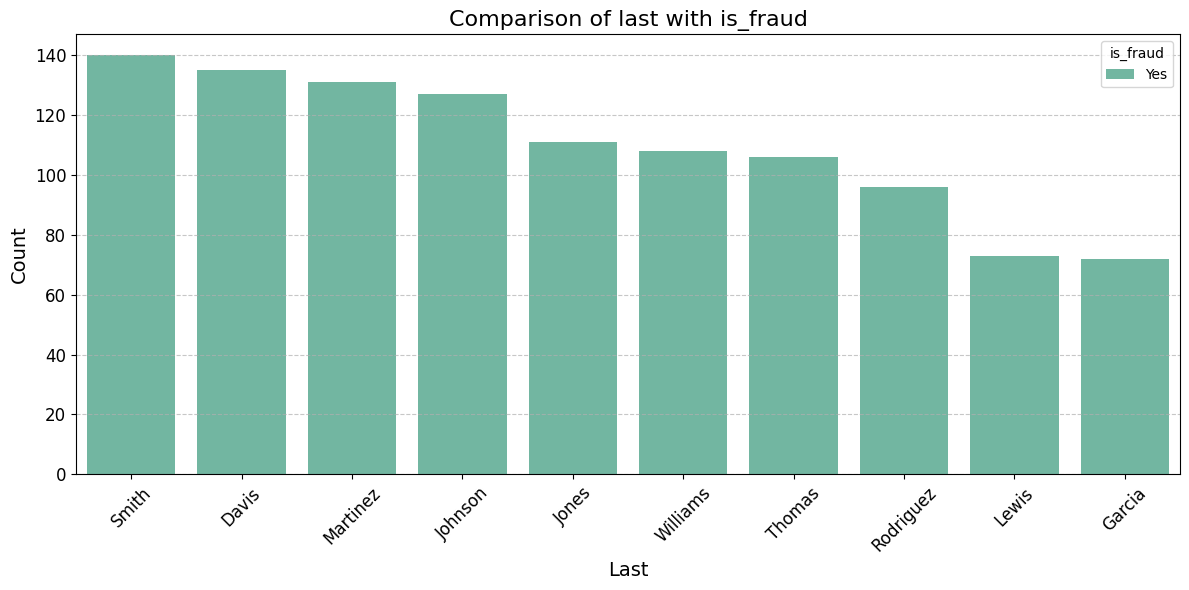

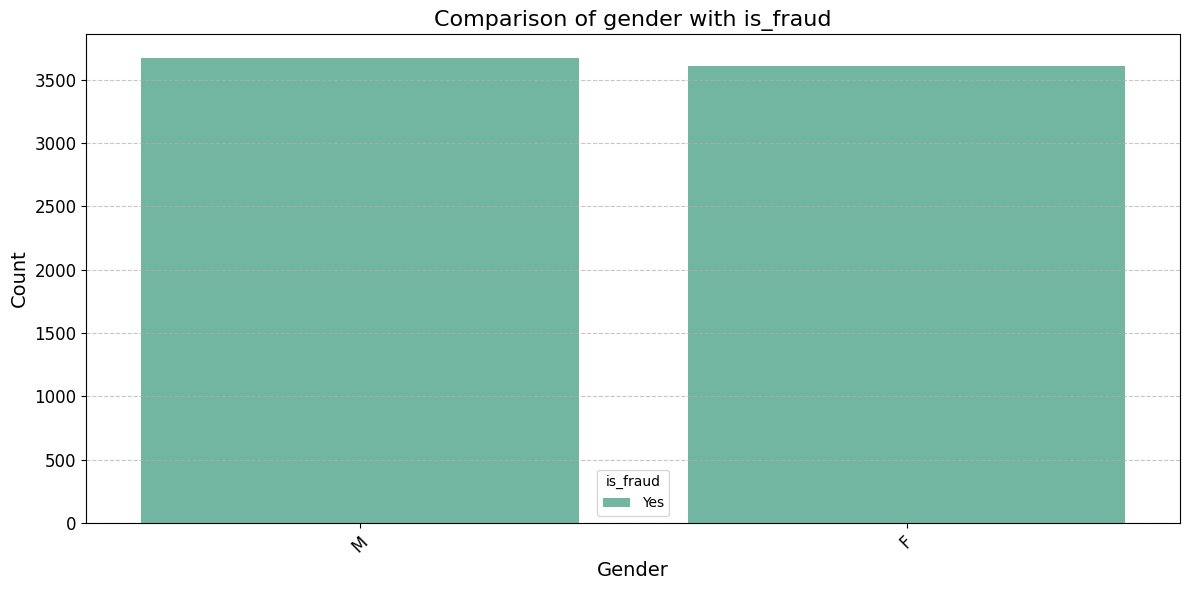

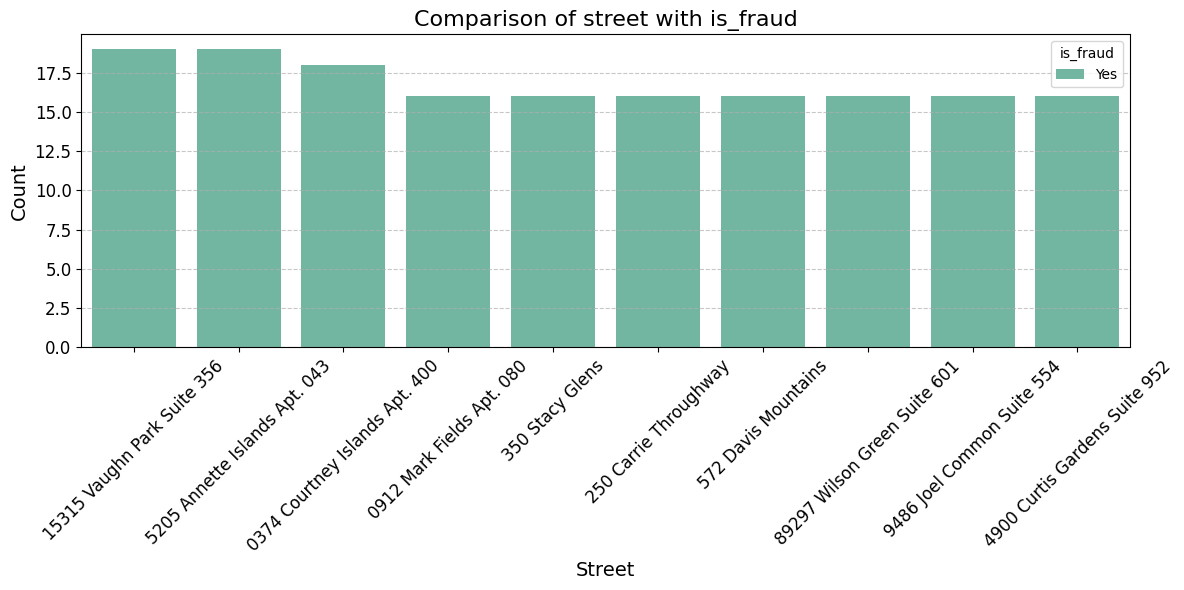

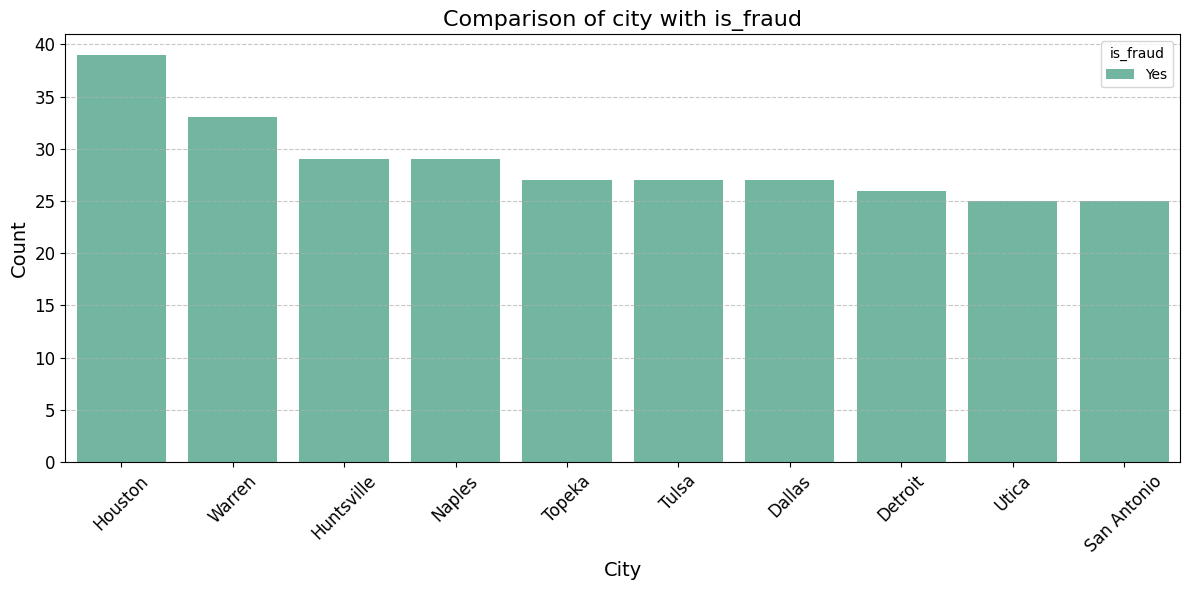

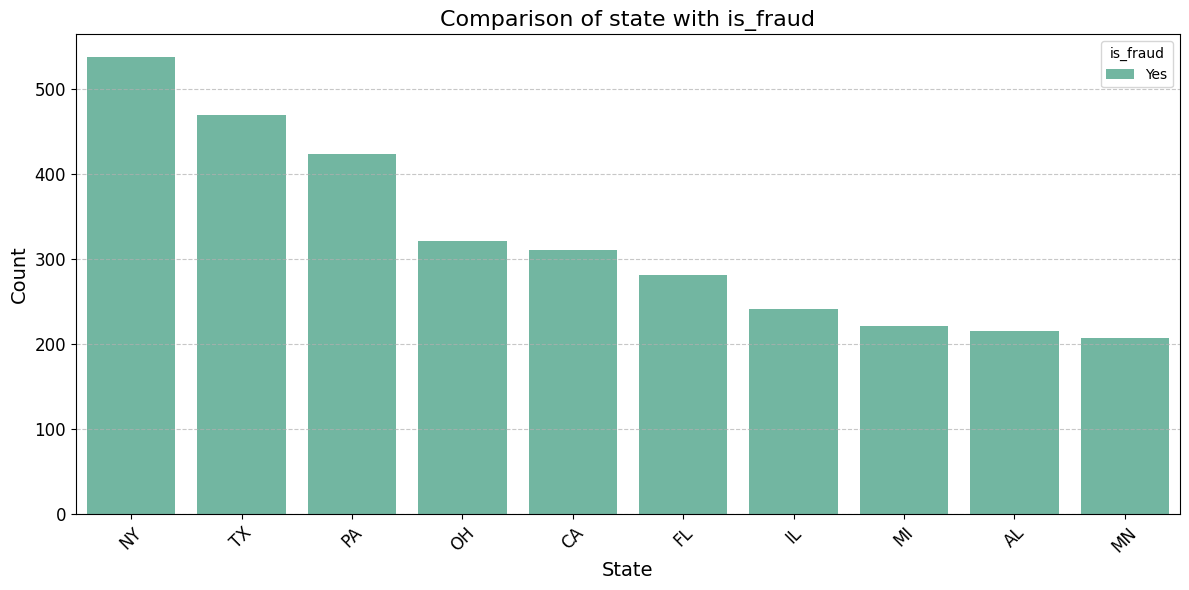

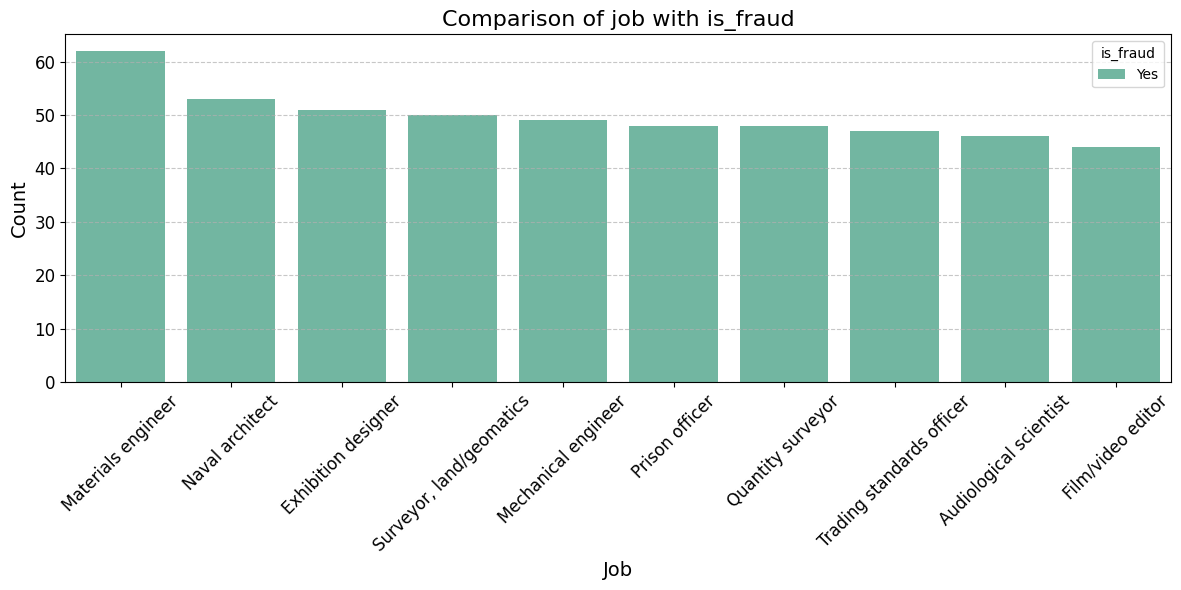

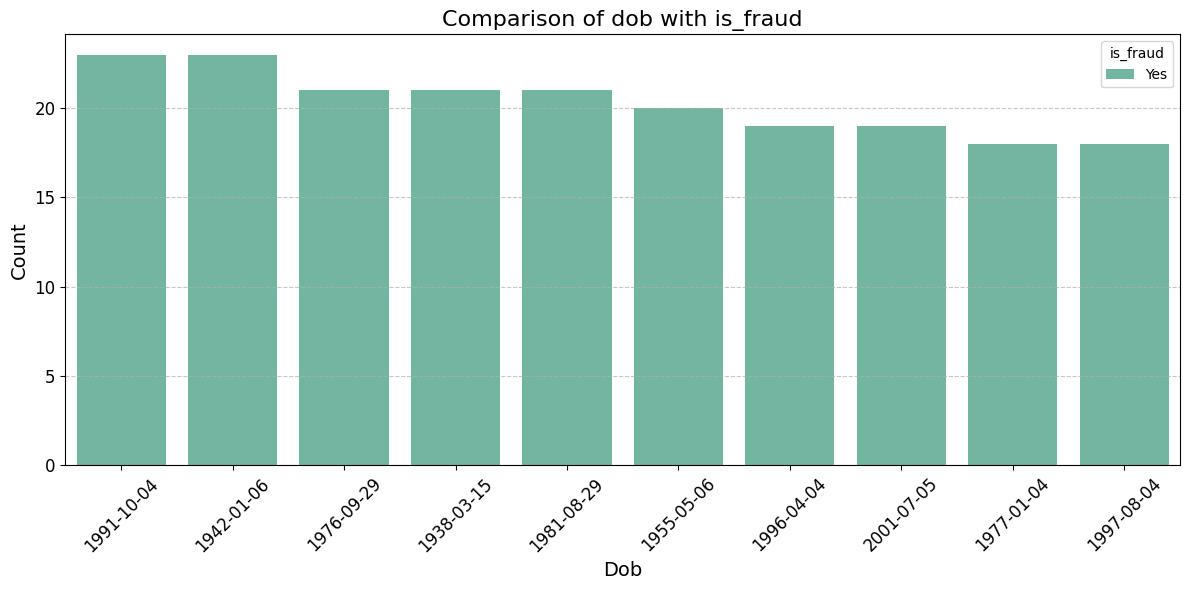

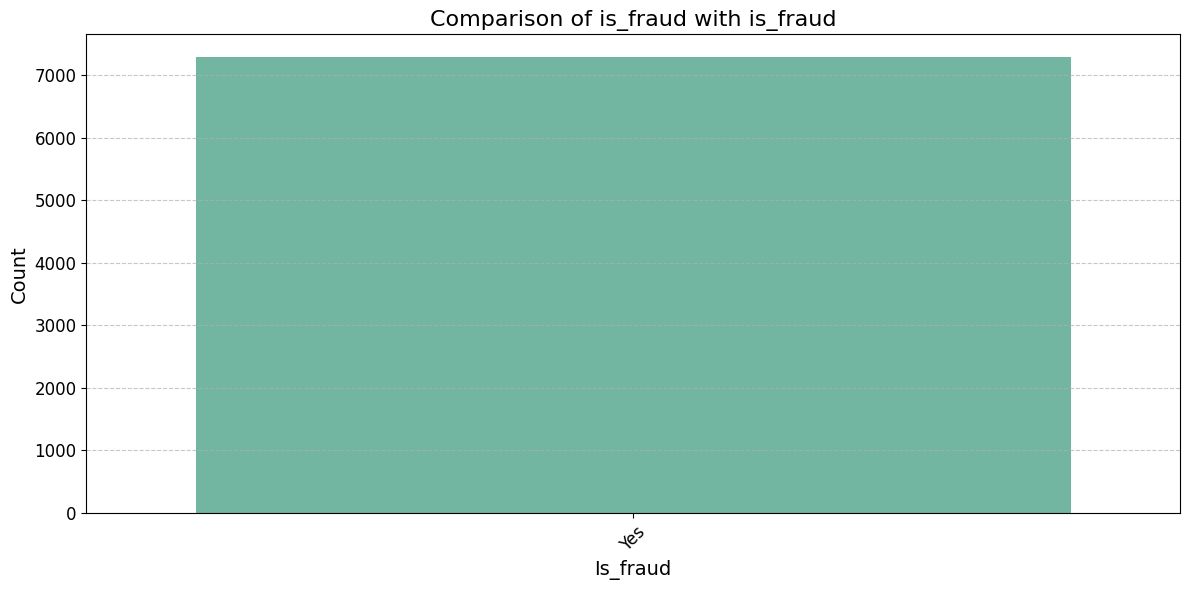

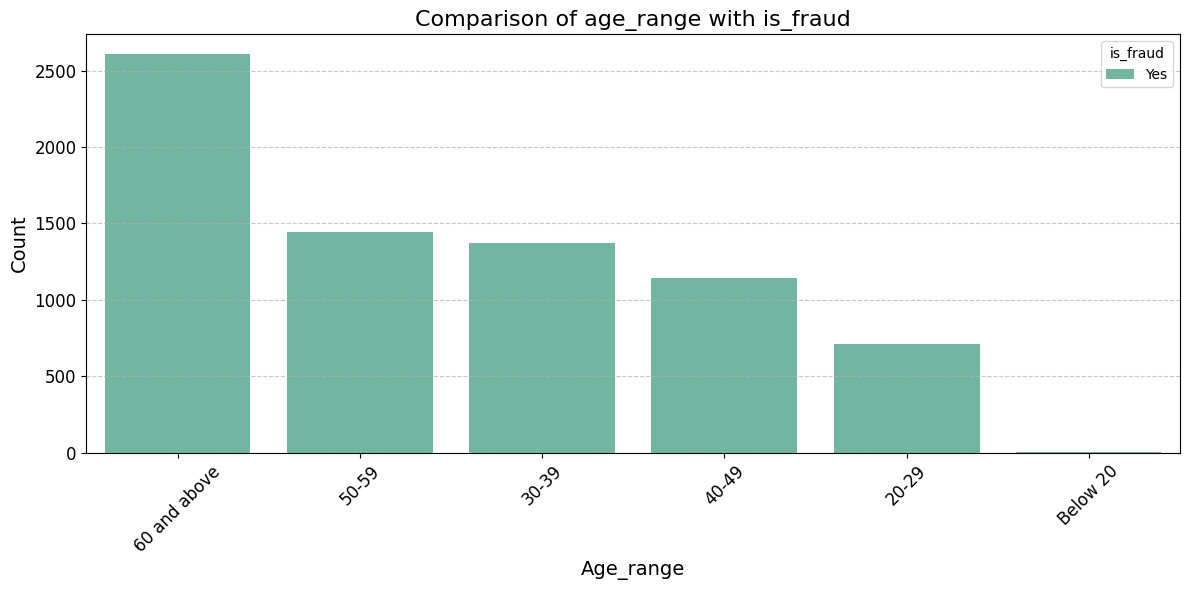

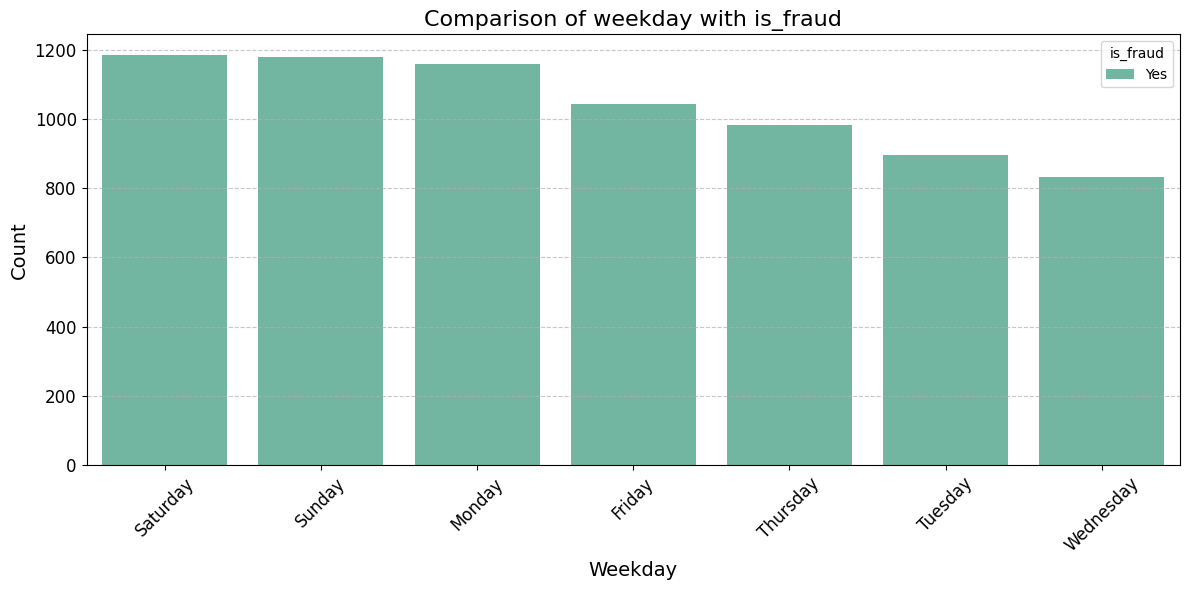

In [61]:
# Compare `is_fraud` with other attributes
# For numerical attributes: Boxplot
# Filter for is_fraud = yes to see the analysis.
credit_card_df_filter_is_fraud = credit_card_df[credit_card_df['is_fraud']== 'Yes']
for col in numerical_fields:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='is_fraud', y=col, data=credit_card_df_filter_is_fraud, palette='Set2')
    plt.title(f'Comparison of {col} with is_fraud', fontsize=16)
    plt.xlabel('Is Fraud', fontsize=14)
    plt.ylabel(col.capitalize(), fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
# For categorical attributes: Countplot
for col in categorical_fields:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=col, hue='is_fraud', data=credit_card_df_filter_is_fraud, palette='Set2', order=credit_card_df_filter_is_fraud[col].value_counts().index[:10])
    plt.title(f'Comparison of {col} with is_fraud', fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

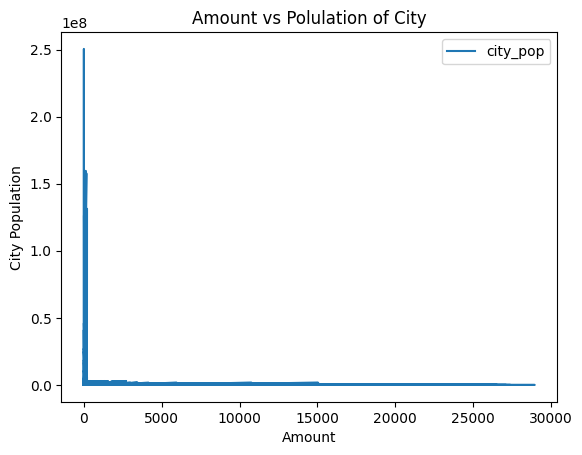

In [62]:
list_numerical_value = ['city_pop']
for col in list_numerical_value:
    plt.plot(credit_card_df['amt'], credit_card_df[col], label=col)
plt.xlabel('Amount')
plt.ylabel('City Population')
plt.title('Amount vs Polulation of City')
plt.legend()
plt.show()

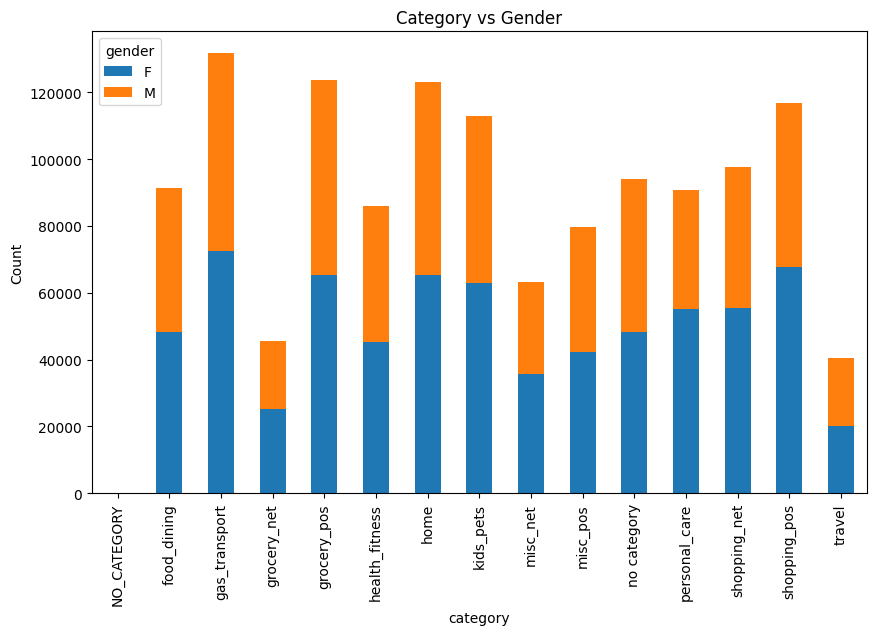

In [63]:
pd.crosstab(credit_card_df['category'], credit_card_df['gender']).plot(
    kind='bar', stacked=True, figsize=(10, 6), title="Category vs Gender"
)
plt.xlabel('category')
plt.ylabel('Count')
plt.show()

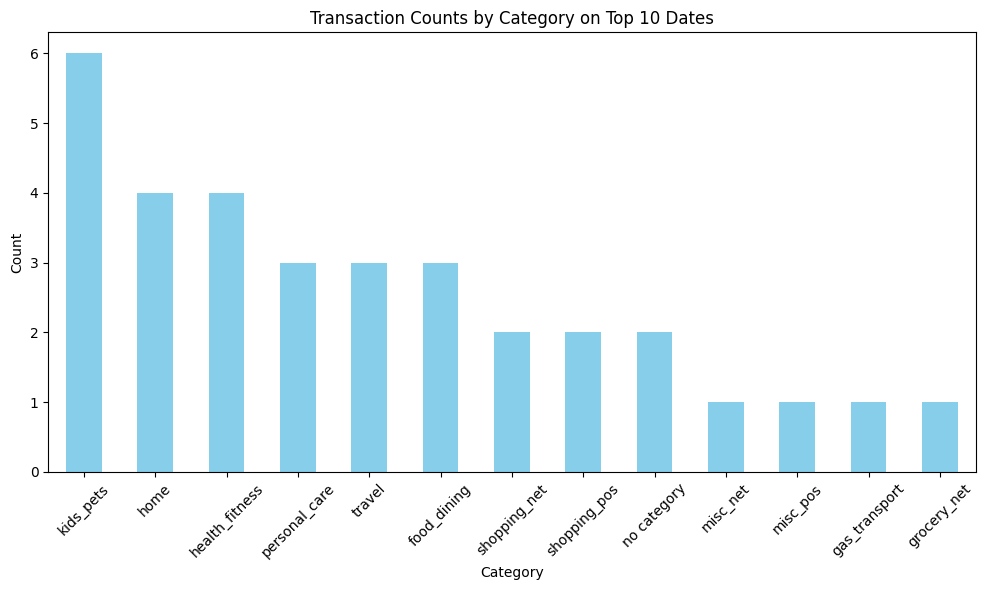

In [64]:
# Get the top 10 dates by transaction frequency
date_attr = credit_card_df['trans_date_trans_time'].value_counts()
top_dates = date_attr[:10].index  # Get the top 10 dates
# Filter the DataFrame to include only transactions on the top 10 dates
filtered_df = credit_card_df[credit_card_df['trans_date_trans_time'].isin(top_dates)]
category_counts = filtered_df['category'].value_counts()
# Plot the category counts
category_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title("Transaction Counts by Category on Top 10 Dates")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

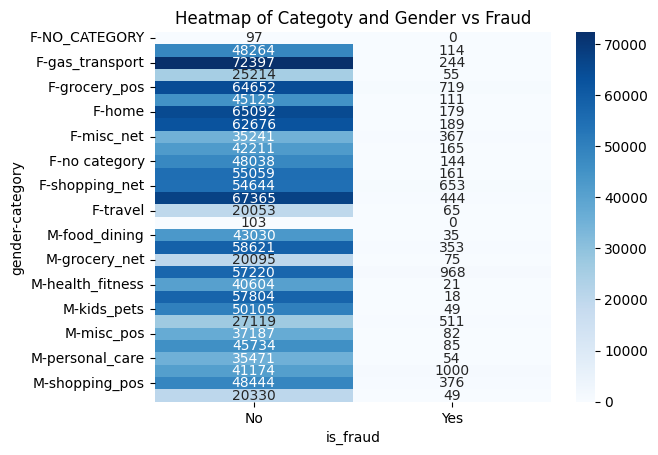

In [65]:
heatmap_data = pd.crosstab(
    [credit_card_df['gender'], credit_card_df['category']],
    credit_card_df['is_fraud']
)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap of Categoty and Gender vs Fraud")
plt.show()

In [66]:
plot_combination_boxplot = [
    ('category', 'amt'),
    ('gender', 'amt'),
    ('trans_date_trans_time', 'zip'),
]

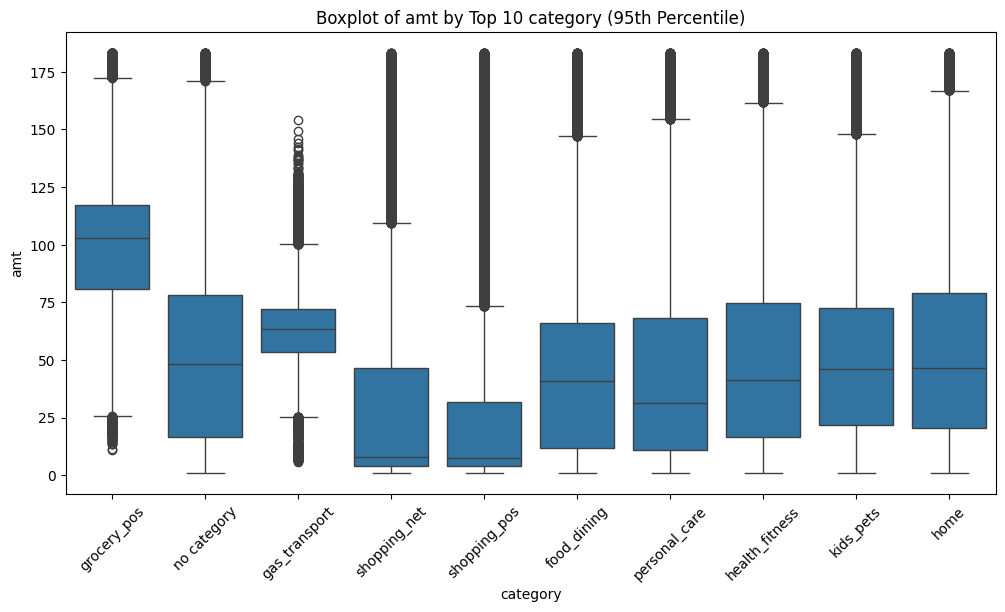

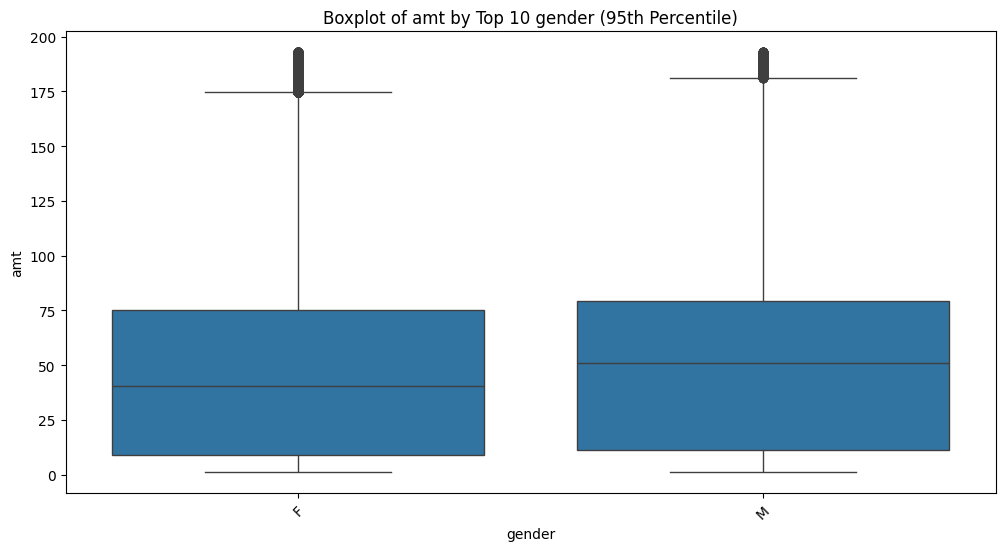

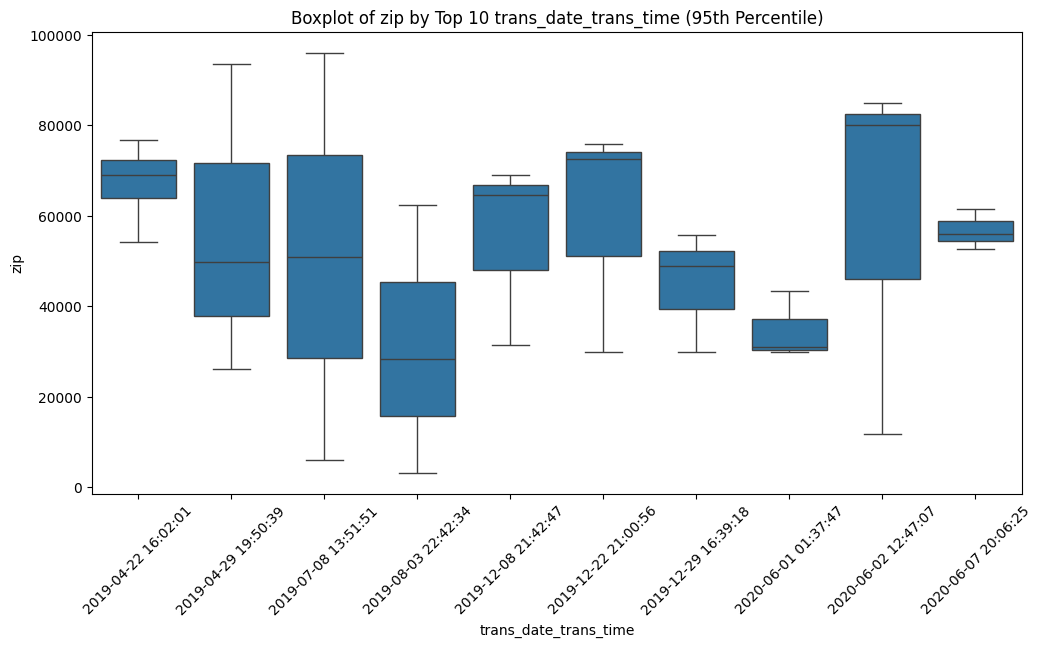

In [67]:
for cat_col,num_col in plot_combination_boxplot:
    # Filter the top 10 categories
    top_10_categories = credit_card_df[cat_col].value_counts().head(10).index
    filtered_df = credit_card_df[credit_card_df[cat_col].isin(top_10_categories)]
    # Filter the numerical column to the 95th percentile
    percentile = filtered_df[num_col].quantile(0.95)
    filtered_df = filtered_df[filtered_df[num_col] <= percentile]
    # Create the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cat_col, y=num_col, data=filtered_df)
    plt.title(f'Boxplot of {num_col} by Top 10 {cat_col} (95th Percentile)')
    plt.xticks(rotation=45)
    plt.show()

In [68]:
plot_combination_barchart = [
    ('city', 'amt'),
    ('gender', 'amt'),
    ('job', 'amt'),
    ('merchant', 'amt')
]

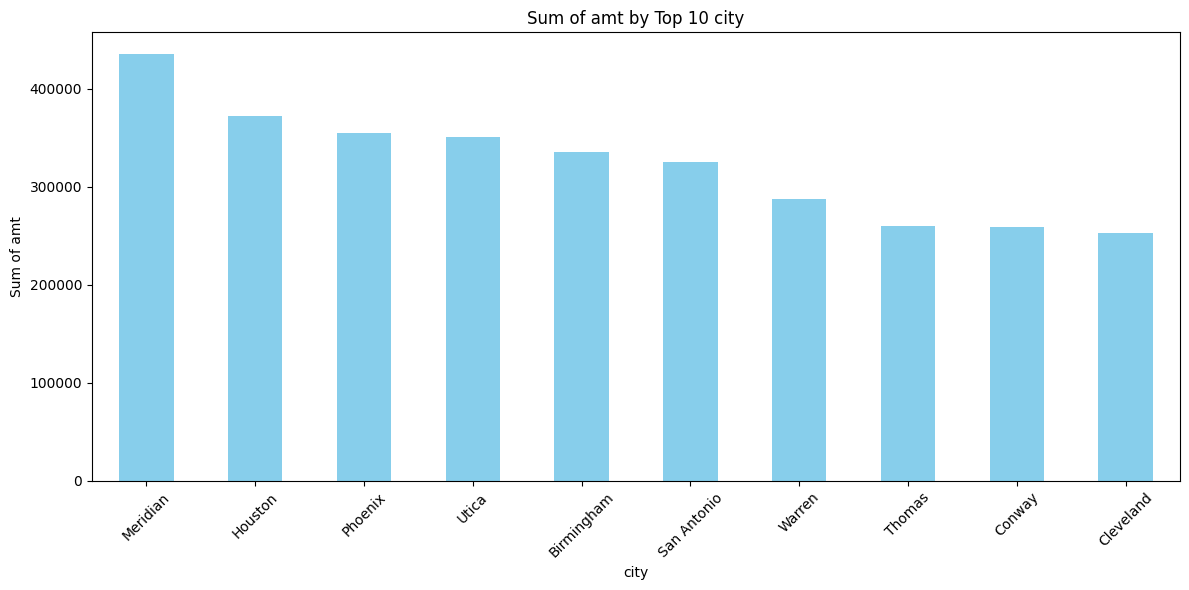

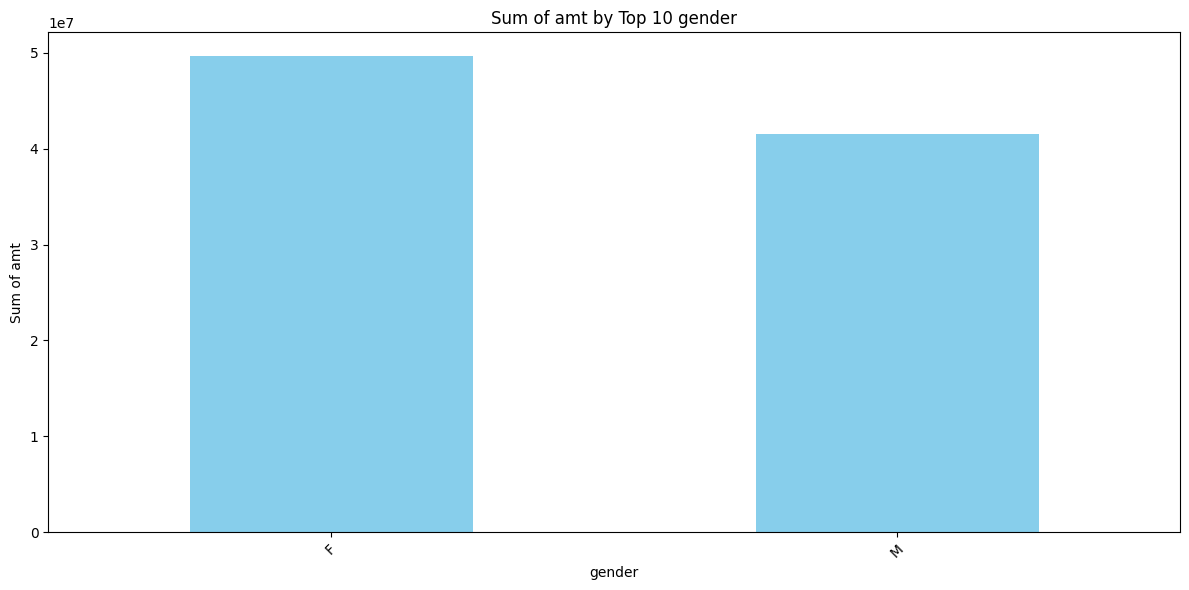

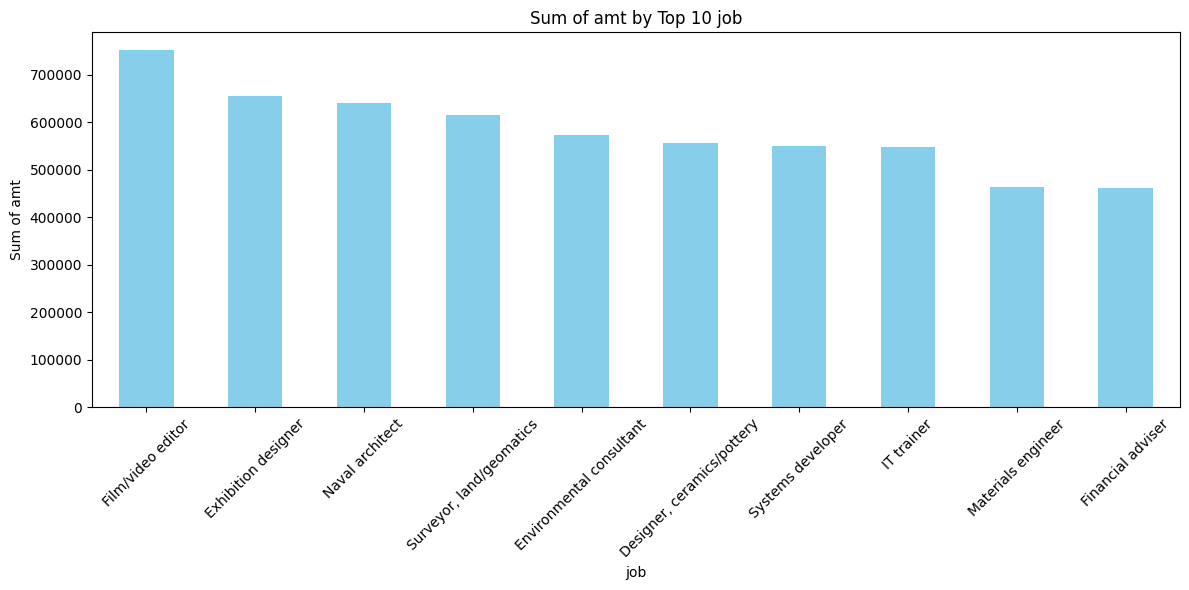

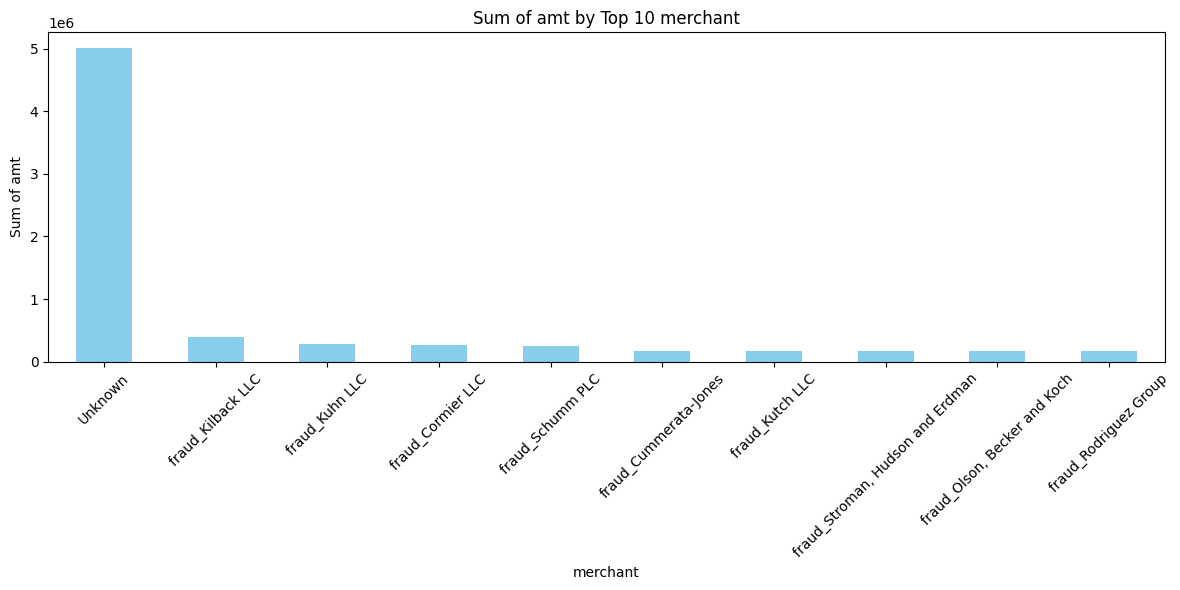

In [69]:
for  cat_col,num_col in plot_combination_barchart:
    # Filter the top 10 categories
    top_10_categories = credit_card_df[cat_col].value_counts().head(10).index
    filtered_df = credit_card_df[credit_card_df[cat_col].isin(top_10_categories)]
    # Aggregate data for the bar chart (sum of numerical values for each category)
    aggregated_data = filtered_df.groupby(cat_col)[num_col].sum().sort_values(ascending=False)
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    aggregated_data.plot(kind='bar', color='skyblue')
    plt.title(f'Sum of {num_col} by Top 10 {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel(f'Sum of {num_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to prevent cutoff
    plt.show()

In [70]:
# Save the updated dataframe to a CSV file
credit_card_df.to_csv('updated_credit_card_data.csv', index=False)
print("CSV file saved as 'updated_credit_card_data.csv'")

CSV file saved as 'updated_credit_card_data.csv'


# Dataset Overview and Descriptions

## Introduction
This dataset contains detailed information about credit card transactions, including metadata, transaction details, demographic data, and fraud indicators. It is structured to allow analysis of patterns, detection of fraudulent activities, and relationships between variables.

---


## Purpose
The dataset is structured to facilitate:
1. Fraud detection through comparative analysis of `is_fraud` against other attributes.
2. Behavioral analysis of transaction patterns based on demographic, geographic, and temporal data.
3. Exploration of correlations between attributes for predictive modeling and insights.

---

## Summary
This dataset combines temporal, spatial, and personal dimensions, enabling a holistic approach to understanding credit card transactions and identifying anomalies.


# Data Definition and Profile for Final Dataset

| **Attribute**          | **Description**                                     | **Data Type** | **Unique Values** | **Most Frequent Value**       | **Minimum Value** | **Maximum Value** | **Mean Value**      | **Examples**                            |
|-------------------------|-----------------------------------------------------|---------------|-------------------|-------------------------------|--------------------|-------------------|--------------------|-----------------------------------------|
| `trans_date_trans_time` | Timestamp of the transaction including date & time | Categorical   | 7,780             | 2019-01-01 16:52:19          | N/A                | N/A               | N/A                | 2019-01-01 00:00:18, 2019-02-01 23:55:02 |
| `cc_num`               | Credit card number used for the transaction         | Numerical     | N/A               | N/A                           | 6041621111111111   | 4992346123456789  | 4.302474e+17       | 2703186189652095, 375534208663984        |
| `merchant`             | Merchant where the transaction occurred             | Categorical   | 647               | Unknown                      | N/A                | N/A               | N/A                | fraud_Rippin, Unknown                   |
| `category`             | Merchant transaction category                       | Categorical   | 15                | gas_transport                | N/A                | N/A               | N/A                | grocery_pos, gas_transport, no category |
| `amt`                  | Transaction amount in USD                           | Numerical     | N/A               | N/A                           | 1.01               | 3,178.51          | 69.00              | 23.45, 150.00, 567.89                   |
| `is_fraud`             | Indicates fraudulent transaction or not             | Categorical   | 2                 | No                           | N/A                | N/A               | N/A                | Yes, No                                 |
| `city`                 | City of the transaction                             | Categorical   | 832               | San Antonio                  | N/A                | N/A               | N/A                | Phoenix, Orient, San Antonio            |
| `state`                | State of the transaction                            | Categorical   | 50                | TX                           | N/A                | N/A               | N/A                | CA, TX, NY                              |
| `city_pop`             | Population of the city                              | Numerical     | N/A               | N/A                           | 10                 | 8,398,748         | 68,572             | 3,495, 149, 4,154                       |
| `job`                  | Occupation of the cardholder                        | Categorical   | 476               | JOBLESS                      | N/A                | N/A               | N/A                | Designer, JOBLESS                       |
| `dob`                  | Date of birth of the cardholder                     | Categorical   | Many              | N/A                           | N/A                | N/A               | N/A                | 1988-03-09, 1978-06-21                 |
| `age_range`            | Age range category of the cardholder                | Categorical   | 6                 | N/A                           | N/A                | N/A               | N/A                | 20-29, 30-39, 40-49                     |

